# Search: Solving a Maze Using a Goal-based Agent

Student Name: [3122410035 -  Nguyễn Khải Ca
               3122410040  -  Đặng Văn Chiến
               3120410098 - Đỗ Trịnh Mỹ Duyên
              ]

I have used the following AI tools: []

I understand that my submission needs to be my own work: [your initials]

## Learning Outcomes

* Formulate search problems using key components like initial state, actions, and goal state in a deterministic, fully observable environment.
* Implement and compare search algorithms including BFS, DFS, GBFS, A*, and IDS for pathfinding in mazes.
* Analyze algorithm performance by measuring path cost, node expansions, depth, and memory usage across various maze types.
* Use visualization tools to represent maze paths and support debugging and analysis.

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the notebook file and the completely rendered notebook with all outputs as a HTML file. 


## Introduction

The agent must use a map it is given to plan a path through the maze from the starting location $S$ to the goal location $G$. This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and can be executed using a model-based reflex agent 
that ignores all percepts and just follows the plan. We do not implement it in this exercise.

Given that the agent has a complete and correct map, the environment is **fully observable, discrete, deterministic, and known.** 
Remember:

* **Fully observable** means that the agent can see its state and what the available actions are. That means the **percepts contain the complete current state.**
Here, during planning, the agent always sees its x and y coordinates on the map and
also seeks when it has reached the goal state. 
* **Discrete** means that we have a **finite set of states.** The maze has a finite set 
of squares the agent can be in.
* **Deterministic** means that the **transition function contains no randomness.** An action in a state will always produce the same result. Going south from the start state always will lead to the same square.
* **Know** means that the agent **knows the complete transition function.** The 
agent has the map and therefore knows how its position changes when it walks in a direction.

Tree search algorithm implementations that you find online typically come from data structures courses and have a different aim than AI tree search. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root note to the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible. 

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [2]:
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



**Note:** If you get an error here that the file cannot be found, then you need to download it. See [HOWTO Work on Assignments.](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/working_on_assignments.md)

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`. 

In [3]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

mh.show_maze
# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

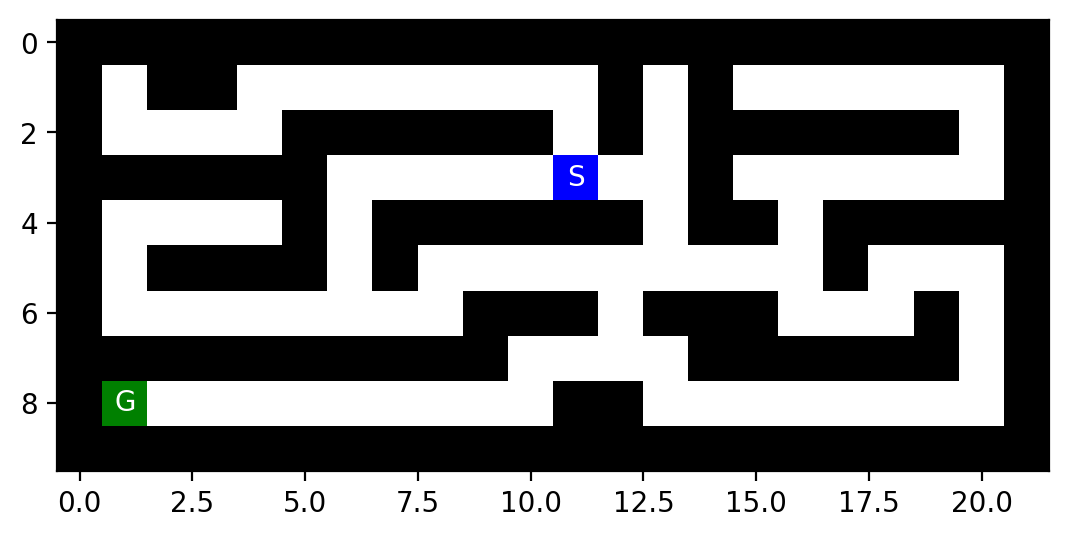

In [4]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebooks

mh.show_maze(maze)

Find the `(x,y)` position of the start and the goal using the helper function `find_pos()`

In [5]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (np.int64(3), np.int64(11))
Goal location: (np.int64(8), np.int64(1))


Helper function documentation.

In [6]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage:
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    animate_maze(result, repeat=False)
        Build an animation from a list of mazes. Assumes that results has the elements:
        path, reached, actions and maze_anim with a list of maze arrays.

    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one.
        Caution: there is no error checking!

        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)

        Returns:
        a tupple (x, y) for the found position.

    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).

    maze_to_matrix(maze)
        convert a maze a numeric numpy array for visualization via imshow.

    parse_maze(maze_str)
        Co

You will need to make a local copy of the module file [maze_helper.py](maze_helper.py) in the same folder where your notebook is.

## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [7]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]
    
        while not node.parent is None:
            node = node.parent
            path.append(node)
        
        path.reverse()
        
        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the 
    - [small maze](small_maze.txt), 
    - [medium maze](medium_maze.txt), 
    - [large maze](large_maze.txt), 
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally. 
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable and contains all figures.
4. Document your code. Use comments in the code and add a discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate. 

*Note:* You can swich the next block from code to Markdown and use formating.

# Your answer goes here
* Initial state: Trạng thái ban đầu là trạng thái nơi các tác nhân bắt đầu.
* Goal state: Trạng thái đích có thể là một tập nhỏ với các trạng thái đích riêng biệt, và cũng  là trạng thái đích được xác định bởi một thuộc tính áp dụng cho nhiều trạng thái(có khả năng vô hạn).  VD: Trong thế giới máy hút bụi, thì đích có thể là không có bụi bẩn ở bất kỳ vị trí nào.
* Actions(Hành động): Tác nhân có thể di chuyển đến các ô liền kề(lên, xuống, trái, phải) nếu ô đó không phải là tưởng('X').
* Transition model: được mô tả là những gì mà action - hành động thực hiện. 
* Path cost: Chi phí một đường đi là tổng chi phí của các hành động trên đường đi đó từ trạng thái ban đầu đến trạng thái hiện tại.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determin these values for a given maze.

# Your answer goes here

* 1.Trạng thái ban đầu: Đối với trạng thái ban đầu, tác nhân bắt đầu tại vị trí bắt đầu được đánh dấu theo mê cung đang xét. Điều này được biểu thị bằng chữ S trong mê cung hoặc hình vuông màu xanh lam như trong hình minh họa.

* 2.Hành động: Đối với các hành động mà tác nhân của tôi có thể thực hiện, tác nhân có thể đi lên, sang phải, xuống hoặc sang trái miễn là không bị tường chắn. Các hành động này được thiết lập cố định bởi mê cung, nhưng các hành động cũng bị giới hạn bởi các ô vuông đã được đi qua. Tác nhân sẽ không đi qua các ô vuông đã đi qua trước đó.

* 3.Mô hình chuyển tiếp: Đối với mô hình chuyển tiếp, một trạng thái liên tiếp được đạt được bằng bất kỳ hành động nào mà tác nhân chọn thực hiện. Mỗi trạng thái liên tiếp mà tác nhân đạt được có thể không hợp lý khi nhìn từ trên xuống, nhưng cuối cùng tác nhân sẽ có thể đạt được mục tiêu thông qua các trạng thái này.

* 4.Trạng thái mục tiêu: Trạng thái mục tiêu ở đây là vị trí kết thúc được đánh dấu bởi mê cung. Điều này được biểu thị bằng chữ G trong mê cung hoặc hình vuông màu xanh lục như trong hình minh họa.

* 5.Chi phí đường đi: Chi phí đường đi trong bài toán này là số bước đi từ vị trí xuất phát đến vị trí đích. Có thể thấy điều này bằng một đường màu đỏ trong hình ảnh minh họa sau khi một mê cung đã được giải quyết. Ở đây, mỗi bước có chi phí là 1.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

Read the following **important notes** carefully:
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and **do not store information in the map.** Only store information in the tree created during search, and use the `reached` and `frontier` data structures where appropriate.
* DSF behavior can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, this would be a big mistake since it combines the bad space complexity of BFS with the bad time complexity of DFS! **To take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure (often also called `visited` or `explored`) and by releasing the memory for nodes that are not needed anymore.**
* Since the proper implementation of DFS does not use a `reached` data structure, redundant path checking abilities are limited to cycle checking. 
You need to implement **cycle checking since DSF is incomplete (produces an infinite loop) if cycles cannot be prevented.** You will see in your experiments that cycle checking in open spaces is challenging.

In [70]:
# Your code goes here
from collections import deque

# Node class theo pseudocode (tree structure)
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state  # (row, col)
        self.parent = parent  # Node cha
        self.action = action  # 'up', 'down', 'left', 'right'
        self.path_cost = path_cost  # Số bước từ start

def load_maze(filename):
    try:
        with open(filename, 'r') as f:
            grid = [list(line.strip()) for line in f.readlines() if line.strip()]  # Bỏ dòng trống
    except FileNotFoundError:
        raise ValueError(f"File {filename} không tồn tại! Tạo file test đi.")
    
    start = None
    goal = None
    rows = len(grid)
    if rows == 0:
        raise ValueError("Grid rỗng!")
    
    cols = len(grid[0])
    for r in range(rows):
        if len(grid[r]) != cols:
            raise ValueError("Grid không đều!")
        for c in range(cols):
            if grid[r][c] == 'S':
                start = (r, c)
                grid[r][c] = '.'  # Treat as open
            elif grid[r][c] == 'G':
                goal = (r, c)
                grid[r][c] = '.'  # Treat as open
    
    if start is None or goal is None:
        raise ValueError("Không tìm thấy S hoặc G!")
    
    return grid, start, goal

# Hàm extract path từ goal node (trace parent)
def extract_path(goal_node):
    path = []
    current = goal_node
    while current:
        path.append(current.state)
        current = current.parent
    return path[::-1]  # Reverse để từ start → goal

# Successors (giả sử từ Task 1; nếu chưa, thêm)
directions = [(-1, 0, 'up'), (1, 0, 'down'), (0, -1, 'left'), (0, 1, 'right')]
def successors(state, grid):
    r, c = state
    succ = []
    for dr, dc, action in directions:
        nr, nc = r + dr, c + dc
        n_rows, n_cols = len(grid), len(grid[0])
        if 0 <= nr < n_rows and 0 <= nc < n_cols and grid[nr][nc] != '#':
            succ.append((action, (nr, nc)))
    return succ

# BFS: Queue fringe, reached set (complete + optimal)
def bfs(start, goal, grid):
    root = Node(start)
    fringe = deque([root])  # Queue: FIFO
    reached = {start: root}  # Dict state → node (cho lookup parent)
    
    while fringe:
        node = fringe.popleft()  # Pop left (FIFO)
        if node.state == goal:
            return extract_path(node), node.path_cost
        
        for action, next_state in successors(node.state, grid):
            if next_state not in reached:
                child = Node(next_state, node, action, node.path_cost + 1)
                fringe.append(child)
                reached[next_state] = child  # Mark reached
    
    return None, float('inf')  # No path

# DFS: Stack fringe, no reached (chỉ cycle check in path)
def dfs(start, goal, grid):
    root = Node(start)
    fringe = deque([root])  # Stack: LIFO (pop right)
    
    while fringe:
        node = fringe.pop()  # Pop right (LIFO)
        if node.state == goal:
            return extract_path(node), node.path_cost
        
        # Cycle check: Tạo set path hiện tại (ancestors)
        path_set = set()
        current = node
        while current:
            path_set.add(current.state)
            current = current.parent
        
        for action, next_state in successors(node.state, grid):
            if next_state not in path_set:  # Không quay lại ancestor (cycle check)
                child = Node(next_state, node, action, node.path_cost + 1)
                fringe.append(child)  # Push right (LIFO)
    
    return None, float('inf')  # No path (có thể infinite nếu cycles lớn)

# Test ví dụ (giả sử grid, start, goal từ load_maze('small_maze.txt'))
grid, start, goal = load_maze('small_maze.txt')
path_bfs, cost_bfs = bfs(start, goal, grid)
print(f"BFS Path: {path_bfs}, Cost: {cost_bfs}")
path_dfs, cost_dfs = dfs(start, goal, grid)
print(f"DFS Path: {path_dfs}, Cost: {cost_dfs}")

BFS Path: [(3, 11), (4, 11), (5, 11), (6, 11), (7, 11), (8, 11), (8, 10), (8, 9), (8, 8), (8, 7), (8, 6), (8, 5), (8, 4), (8, 3), (8, 2), (8, 1)], Cost: 15
DFS Path: [(3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (4, 21), (4, 20), (4, 19), (4, 18), (4, 17), (4, 16), (4, 15), (4, 14), (4, 13), (4, 12), (4, 11), (4, 10), (4, 9), (4, 8), (4, 7), (4, 6), (4, 5), (4, 4), (4, 3), (4, 2), (4, 1), (4, 0), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10), (5, 11), (5, 12), (5, 13), (5, 14), (5, 15), (5, 16), (5, 17), (5, 18), (5, 19), (5, 20), (5, 21), (6, 21), (6, 20), (6, 19), (6, 18), (6, 17), (6, 16), (6, 15), (6, 14), (6, 13), (6, 12), (6, 11), (6, 10), (6, 9), (6, 8), (6, 7), (6, 6), (6, 5), (6, 4), (6, 3), (6, 2), (6, 1), (6, 0), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (7, 9), (7, 10), (7, 11), (7, 12), (7, 13), (7, 14), (7, 15), (7, 16), (7, 17), (7, 18), (7, 19), 

How does BFS and DFS (without a reached data structure) deal with loops (cycles)?

## Thảo Luận: BFS Và DFS Xử Lý Loops (Cycles) Như Thế Nào?

- **BFS (với reached set)**: Hoàn toàn tránh cycles bằng cách dùng reached set (global visited). Khi generate successor, nếu next_state đã trong reached, bỏ qua → không mở rộng node lặp. Điều này làm BFS **complete** (tìm path nếu tồn tại) và **optimal** (ngắn nhất). Trong mê cung open spaces (nhiều cycles), reached ngăn loop hiệu quả, nhưng tốn space O(|V|) (V=nodes).

- **DFS (không reached, chỉ cycle check)**: Chỉ tránh cycles ngắn trong branch hiện tại bằng path_set (set ancestors từ root đến node hiện tại). Nếu next_state trong path_set, bỏ qua → tránh quay lại ngay lập tức (như up rồi down). Tuy nhiên, DFS **không complete** nếu cycles lớn (ngoài branch, ví dụ loop vòng quanh mê cung) → có thể infinite loop ở open spaces (không wall, dễ cycle dài). Trong thí nghiệm, DFS loop nhanh ở mê cung lớn nếu không có walls chặn, dẫn đến timeout hoặc path dài vô tận.

Tóm lại: BFS an toàn hơn với cycles (nhờ reached), DFS tiết kiệm space nhưng rủi ro loop cao ở môi trường có nhiều paths lặp (như mê cung không cấu trúc).

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations? Especially discuss the difference in space complexity between BFS and DFS.

In [10]:
# Discussion

## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides). 

In [11]:
# Your code goes here
import heapq

# Hàm heuristic Manhattan
def manhattan(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# Lấy các láng giềng (4 hướng)
def get_neighbors(node, grid):
    x, y = node
    neighbors = []
    directions = [(0,1),(1,0),(0,-1),(-1,0)]
    for dx, dy in directions:
        nx, ny = x + dx, y + dy
        if 0 <= nx < len(grid) and 0 <= ny < len(grid[0]) and grid[nx][ny] == 0:
            neighbors.append((nx, ny))
    return neighbors

# Greedy Best-First Search
def greedy_best_first_search(grid, start, goal):
    open_set = []
    heapq.heappush(open_set, (manhattan(start, goal), start))
    came_from = {}
    visited = set()
    
    while open_set:
        _, current = heapq.heappop(open_set)
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        visited.add(current)
        
        for neighbor in get_neighbors(current, grid):
            if neighbor not in visited:
                came_from[neighbor] = current
                heapq.heappush(open_set, (manhattan(neighbor, goal), neighbor))
    return None

# A* Search
def a_star_search(grid, start, goal):
    open_set = []
    heapq.heappush(open_set, (manhattan(start, goal), 0, start))
    came_from = {}
    g_score = {start: 0}
    
    while open_set:
        _, g, current = heapq.heappop(open_set)
        
        if current == goal:
            path = []
            while current in came_from:
                path.append(current)
                current = came_from[current]
            path.append(start)
            return path[::-1]
        
        for neighbor in get_neighbors(current, grid):
            tentative_g = g + 1
            if neighbor not in g_score or tentative_g < g_score[neighbor]:
                g_score[neighbor] = tentative_g
                f = tentative_g + manhattan(neighbor, goal)
                came_from[neighbor] = current
                heapq.heappush(open_set, (f, tentative_g, neighbor))
    return None

# Demo
if __name__ == "__main__":
    # 0 = đường đi, 1 = tường
    grid = [
        [0,0,0,0,0],
        [1,1,0,1,0],
        [0,0,0,1,0],
        [0,1,1,1,0],
        [0,0,0,0,0]
    ]
    
    start = (0,0)
    goal = (4,4)
    
    print("Greedy Best-First Search path:")
    print(greedy_best_first_search(grid, start, goal))
    
    print("\nA* Search path:")
    print(a_star_search(grid, start, goal))


Are your implementations complete and optimal? What is the time and space complexity?

# Discussion
Greedy Best-First Search (GBFS):

    Complete (Hoàn chỉnh): Có (nếu có kiểm tra chu trình, như trong code).

    Optimal (Tối ưu): Không.

    Time Complexity: O(b^m) trong trường hợp xấu nhất (b = branching factor, m = độ sâu tối đa).

    Space Complexity: O(b^m).

A* Search:

    Complete (Hoàn chỉnh): Có (nếu h(n) admissible và branching hữu hạn).

    Optimal (Tối ưu): Có (vì Manhattan là admissible).

    Time Complexity: Trung bình O(b^d), nhưng trong trường hợp xấu nhất có thể là O(b^m) (d = độ sâu lời giải tối ưu, m = độ sâu tối đa).

    Space Complexity: O(b^d), do phải lưu cả frontier và bảng g-score.

## Task 4: Comparison and discussion [20 Points] 

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug (likely your frontier and cycle checking for DFS are the issue). If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

# Các hàm bổ trợ và trược quan hóa

Helper functions for the Maze Assignment by M. Hahsler
Usage: 
  import maze_helper as mh
  mh.show_some_mazes()
  
Here is an example maze:

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX

The goal is at (np.int64(8), np.int64(1)).
X


<Figure size 640x480 with 0 Axes>

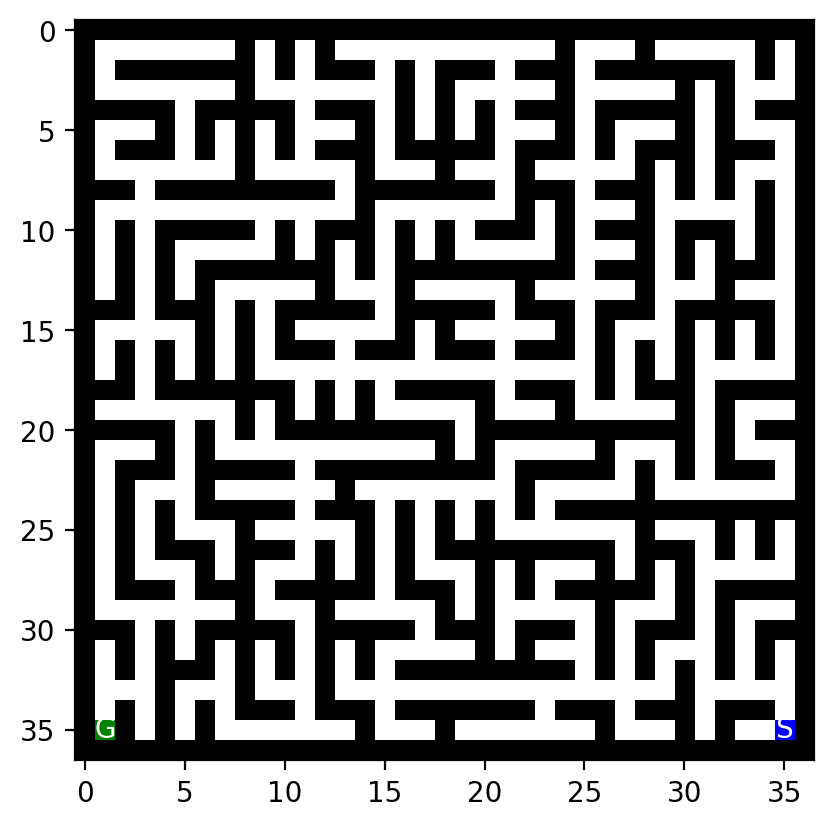

In [62]:
from pyTree.Tree import Tree
import numpy as np

# Mở và chạy helpermaze để phân tích và trực quan hóa mê cung
%run maze_helper.py

# xác định tên maze
maze_names = {
    "small": "small_maze.txt",
    "medium": "medium_maze.txt",
    "large": "large_maze.txt",
    "empty": "empty_maze.txt",
    "L": "L_maze.txt",
    "loops": "loops_maze.txt",
    "open": "open_maze.txt",
    "empty2":"empty_maze_2.txt"
}
# xác định các tham số trong maze
global maze

def load_maze(name):
    maze_read = open(maze_names[name], "r").read()
    return(parse_maze(maze_read))
maze = load_maze("large")
print(maze[8,1])
show_maze(maze)


In [38]:
# hàm tìm vị trí giá trị đã cho trong maze, được sử dụng cho start và goal, tìm thấy lần đầu tiên xảy ra
def find_position(maze, loc = "S"):
    pos_tuple = np.where(maze == loc)
    pos_x = pos_tuple[0][0]
    pos_y = pos_tuple[1][0]
    return([pos_x, pos_y])

find_position(maze, "S")

[np.int64(35), np.int64(35)]

In [39]:
# hàm để kiểm tra các ô đã cho ?
def check_square(maze, pos):
    return(maze[pos[0], pos[1]])

check_square(maze, [3,11])

np.str_(' ')

In [40]:
# Tìm tất cả các nước đi có sẵn trong một hình vuông nhất định bằng cách kiểm tra "X" trong tất cả các ô liền kề
def available_moves(maze, pos, strat = "random"):
    adjacent_locs = np.add(pos, [[-1,0], [0,1], [1,0], [0,-1]])[::-1]
    
    if(strat != "left"):
        np.random.shuffle(adjacent_locs)
        
    possible_moves = [ pos_ok.tolist() for pos_ok in adjacent_locs if check_square(maze,pos_ok) != "X" ]
    
    return possible_moves
    
available_moves(maze, (3,11), strat="left")

[[3, 10], [4, 11], [3, 12], [2, 11]]

In [42]:
def obtain_path(node):
    path = []
    path.append(node.data)
    
    while not node.isRoot():
        node = node.getParent()
        path.append(node.data)
        
    path.reverse()
    return(path)
# Hiển thị đường đã trong 
def show_path(maze, path, reached = []):
    maze_copy = np.copy(maze)
    
    for pos in path:
        if(maze_copy[pos[0],pos[1]] == " "):
            maze_copy[pos[0],pos[1]] = "P"
           
    for pos in reached:
        if (maze_copy[pos[0],pos[1]] == " "):
            maze_copy[pos[0],pos[1]] = "."
            
    show_maze(maze_copy)

# Heuristics

In [43]:
# tìm đồ dài đường đi cho node n
def g(n):
    return(len(obtain_path(n))-1)
# tìm khoảng cách mahattan
def manhattan(pos1, pos2):
    return(np.sum(np.abs(np.subtract(pos1,pos2))))
# tìm vị trí với nước đi nhỏ nhất
def min_move(x):
    return(np.random.choice(np.where(x == np.amin(x))[0]))

# Tree Search
 Hàm này bao gồm các triển khai cho BFS, DFS, GBFS Manhattan và A* Manhattan

In [60]:
def tree_search(maze, strat = "BFS", debug = False, visualize = False):
    # Vị trí start (S) và goal (G)
    start_pos = find_position(maze, "S")
    end_pos = find_position(maze, "G")
    
    if(visualize):
        maze_vis = np.copy(maze)
        
    # gốc cây tìm kiếm
    root = Tree(data = start_pos)
    # Khởi tạo dach sách các node sẽ mở rộng
    frontier = []
    frontier.append(root)
    # Danh sách các node đã reached được
    reached = dict()
    reached[tuple(root.data)] = root
    # Biến theo dõi độ sau và kích thước danh sách frontier
    max_frontier = 0
    max_depth = 0
    # parameters for IDS
    limit_depth_IDS = 0
    # set current node to root since we are just starting
    node = root
    # loop until nothing left in frontier or goal is reached
    while not (len(frontier) < 1):
        # update max frontier size
        if(len(frontier) > max_frontier):
            max_frontier = len(frontier)
            if(debug):
                print("New Max Frontier Length: {}".format(max_frontier))
        if(debug):
            print("Frontier: {}".format([n.data for n in frontier]))
        # choose how to move forward with frontier choice based on strategy
        if(strat == "BFS"):
            # FIFO - Wide
            node = frontier.pop(0)
        elif(strat == "DFS"):
            # LIFO - Deep
            node = frontier.pop(-1)
        elif(strat == "IDS"):
            # LIFO modified - will go deep until limit reached and then expand wide (see below)
            node = frontier.pop(-1)
        elif(strat == "GBFSM"):
            h_n = [manhattan(n.data, end_pos) for n in frontier]
            if(debug):
                print("GBFS manhattan h(n): {}".format(h_n))
            node = frontier.pop(min_move(h_n))
        elif(strat == "A*M"):
            f_n = [g(n) + manhattan(n.data, end_pos) for n in frontier]
            if(debug):
                print("A* manhattan f(n): {}".format(f_n))
            node = frontier.pop(min_move(f_n))
        else:
            print("UNKNOWN STRATEGY!")
            return(None)
        # check to see if reached goal state
        if(check_square(maze, node.data) == "G"):
            return({
                "path": obtain_path(node),
                "reached": reached.keys(),
                "max-frontier": max_frontier,
                "max-depth": max_depth
            })
        # if not reached goal state, expand chosen node
        else:
            if(debug):
                print("Expanding node: {}".format(node.data))
            # if IDS and limit has been reached and frontier is empty, reset to root and increase limit by 1
            #    otherwise, if limit has been reached and frontier still has values, check & expand on those
            #    values
            if(strat == "IDS"):
                if((g(node) == limit_depth_IDS)):
                    if(debug): 
                        print("LIMIT REACHED: ", g(node))
                    if(len(frontier) == 0):
                        root = Tree(data = start_pos)
                        frontier = [root]
                        reached = dict()
                        reached[tuple(root.data)] = root
                        if(visualize):
                            maze_vis = np.copy(maze)
                        limit_depth_IDS = limit_depth_IDS + 1
                    continue
            # go through list of available moves
            for pos in available_moves(maze, node.data):
                # if the available position is in the reached locations and is shorter path, dont add to frontier
                #  prevents getting stuck in a rabbit hole
                if(strat in ["DFS", "GBFS-M", "GBFS-E", "IDS"]):
                    if(tuple(pos) in reached.keys()):
                        if(g(reached[tuple(pos)]) <= g(node)+1):
                            continue
                elif(tuple(pos) in reached.keys()):
                    continue
                # if the available position has not already been added to frontier or is better
                n = Tree(data = pos)
                node.addChild(n)
                if(g(n) > max_depth):
                    max_depth = g(n)
                    if(debug):
                        print("New Max Depth: {}".format(max_depth))
                frontier.append(n)
                reached[tuple(pos)] = n
                if(visualize):
                    maze_vis[pos[0], pos[1]] = "."
            # prevents getting stuck in loops with IDS, this is because the algorithm may run
            #   into another path when the limit has not been reached and due to the reached
            #   dictionary, the algorithm will result in an empty frontier, exiting the search
            if(strat == "IDS" and len(frontier) == 0):
                root = Tree(data = start_pos)
                frontier = [root]
                reached = dict()
                reached[tuple(root.data)] = root
                if(visualize):
                    maze_vis = np.copy(maze)
                limit_depth_IDS = limit_depth_IDS + 1
            
            if(debug):
                print("Adding {} to frontier list.".format([n.data for n in node.getChildren()]))
            
            if(visualize):
                # update visualization with path chosen
                if(maze_vis[node.data[0], node.data[1]] == "."):
                    maze_vis[node.data[0], node.data[1]] = "P"
                show_maze(maze_vis)
                
    # always return at least something :-)            
    return(None)

In [46]:
# Hàm hiện các thuộc tính torng bảng
def maze_runner(strategies):
    print("_________________________________________________________________\n")
    for cur_strat in strategies:
        print("Strategy: {}\n".format(cur_strat))
        for cur_maze in maze_names.keys():
            maze = load_maze(cur_maze)
            results = tree_search(maze, strat = cur_strat, debug = False, visualize = False)
            print("Maze: {}".format(cur_maze))
            print("Path cost: {}".format(len(results["path"])-1))
            print("Squares Explored: {}".format(len(results["reached"])))
            print("Max Frontier: {}".format(results["max-frontier"]))
            print("Max Depth: {}".format(results["max-depth"]))
            show_path(maze, results["path"], results["reached"])
        print("_________________________________________________________________\n")

_________________________________________________________________

Strategy: BFS

Maze: small
Path cost: 19
Squares Explored: 94
Max Frontier: 9
Max Depth: 20


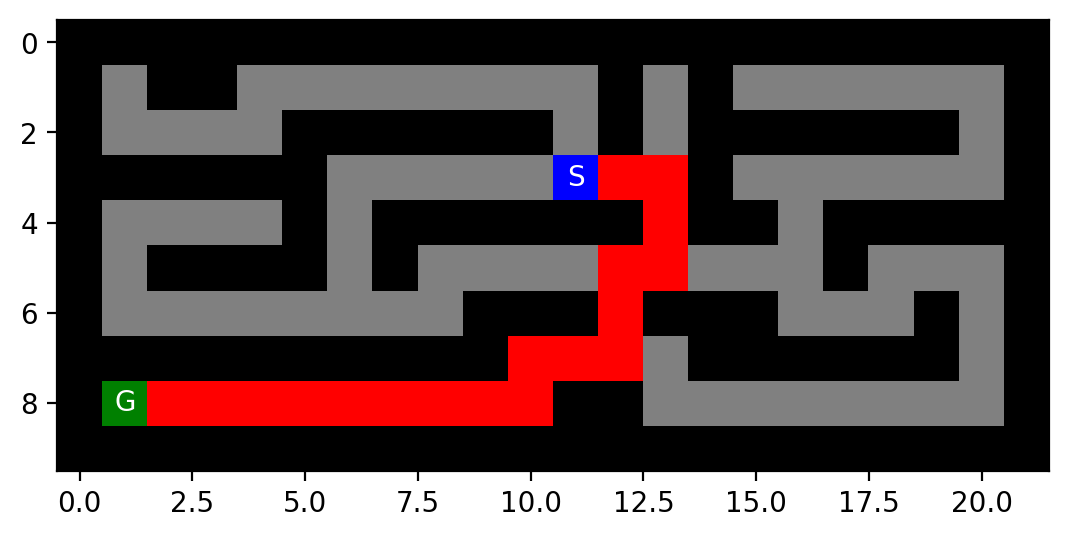

Maze: medium
Path cost: 68
Squares Explored: 272
Max Frontier: 8
Max Depth: 69


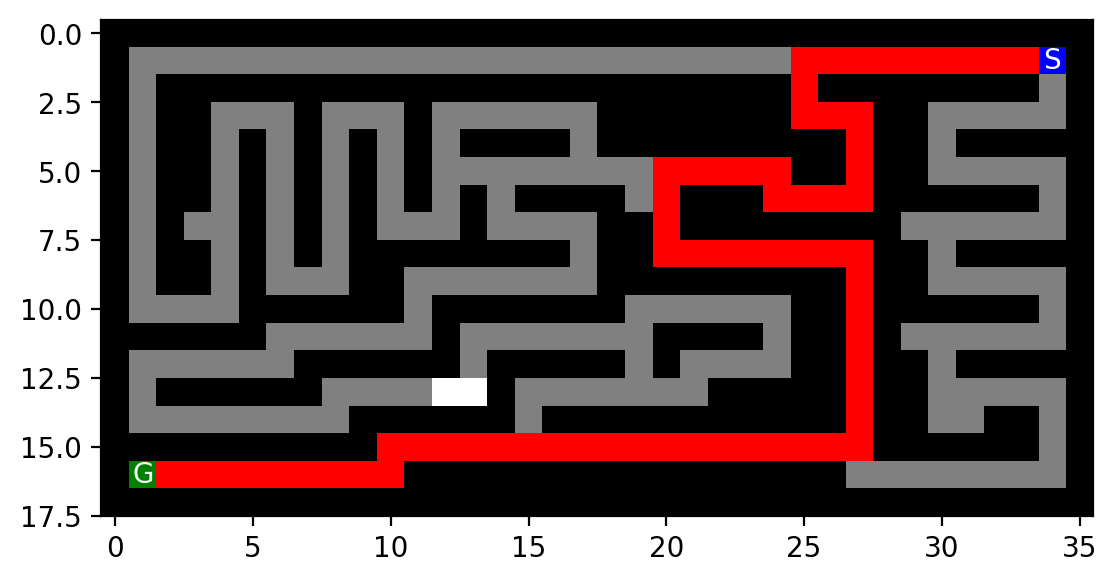

Maze: large
Path cost: 210
Squares Explored: 623
Max Frontier: 8
Max Depth: 210


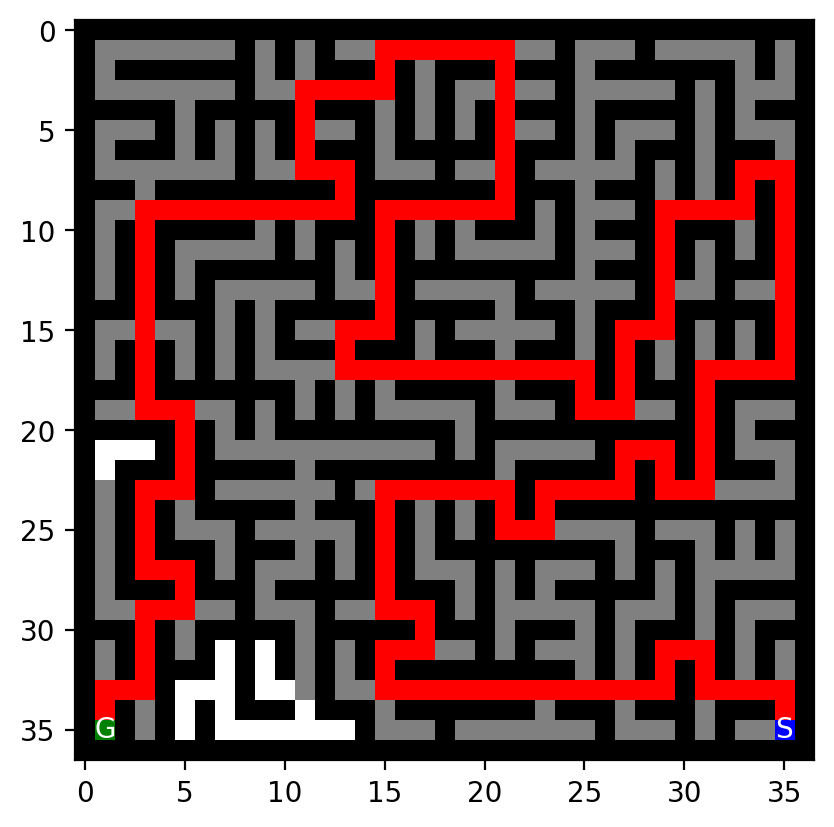

Maze: empty
Path cost: 14
Squares Explored: 98
Max Frontier: 12
Max Depth: 15


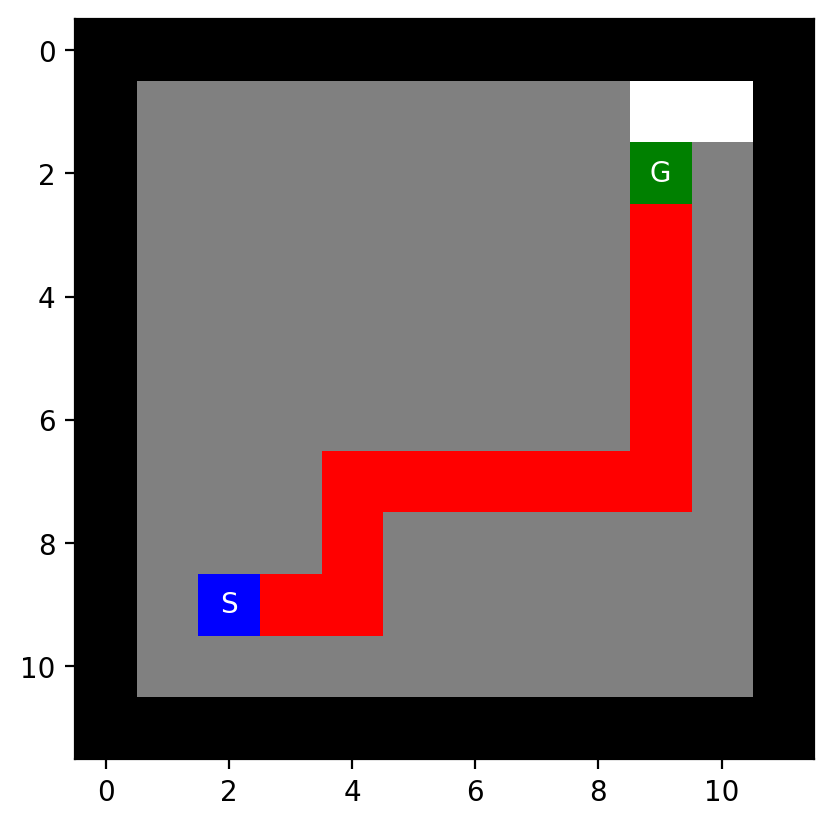

Maze: L
Path cost: 16
Squares Explored: 154
Max Frontier: 19
Max Depth: 17


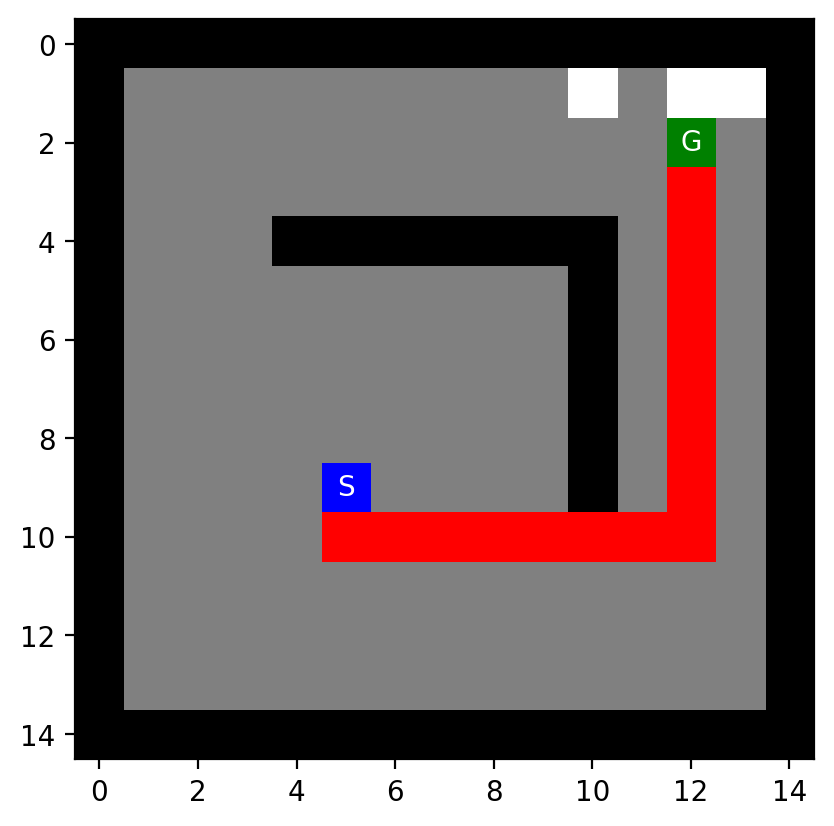

Maze: loops
Path cost: 23
Squares Explored: 72
Max Frontier: 8
Max Depth: 23


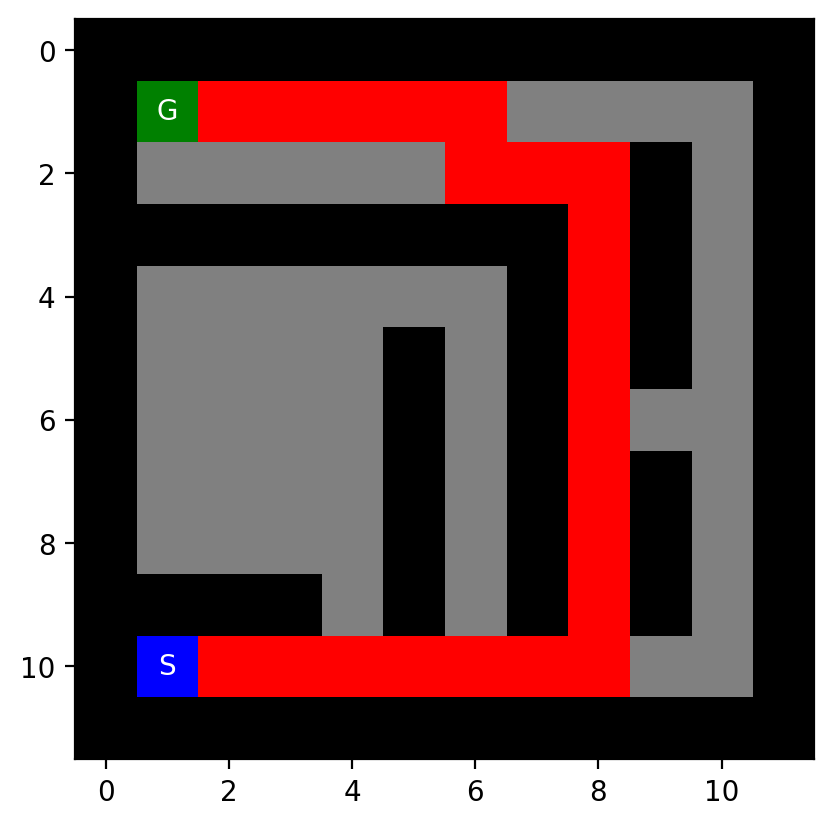

Maze: open
Path cost: 54
Squares Explored: 684
Max Frontier: 25
Max Depth: 54


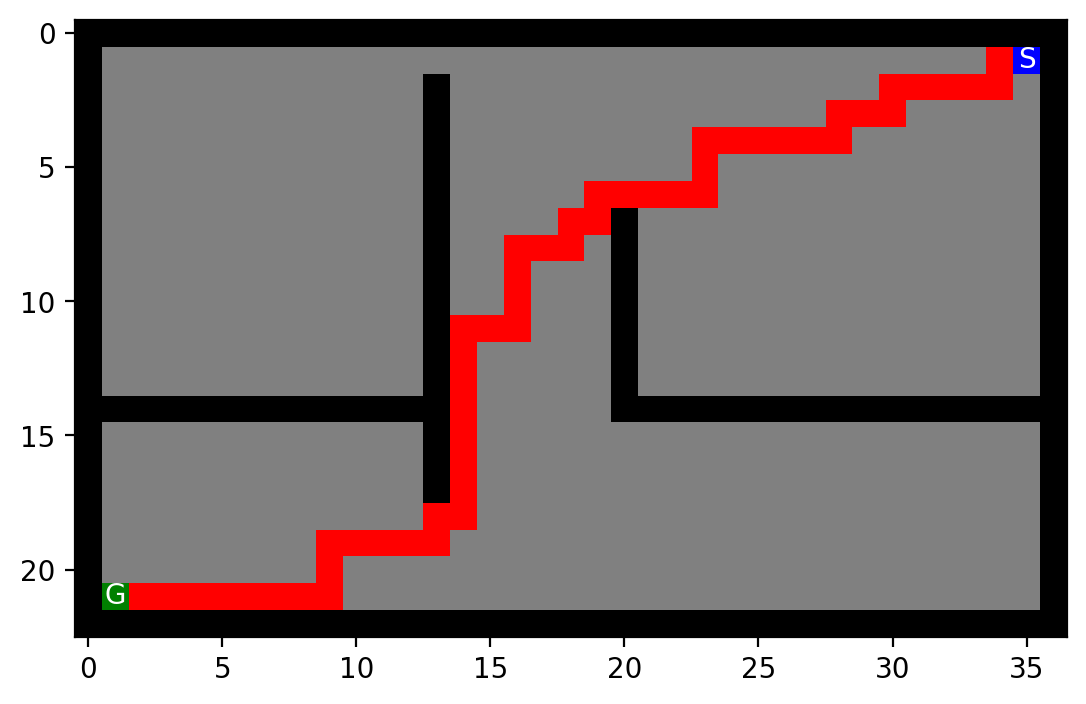

Maze: empty2
Path cost: 14
Squares Explored: 98
Max Frontier: 12
Max Depth: 15


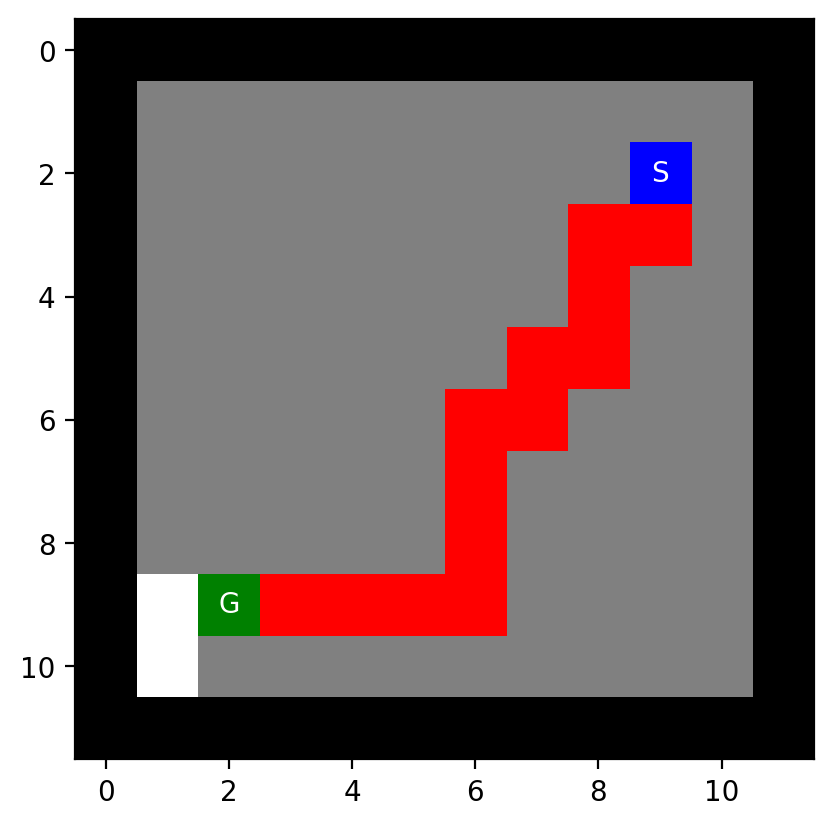

_________________________________________________________________



In [63]:
strategies = ["BFS"]
maze_runner(strategies)

_________________________________________________________________

Strategy: DFS

Maze: small
Path cost: 37
Squares Explored: 57
Max Frontier: 7
Max Depth: 37


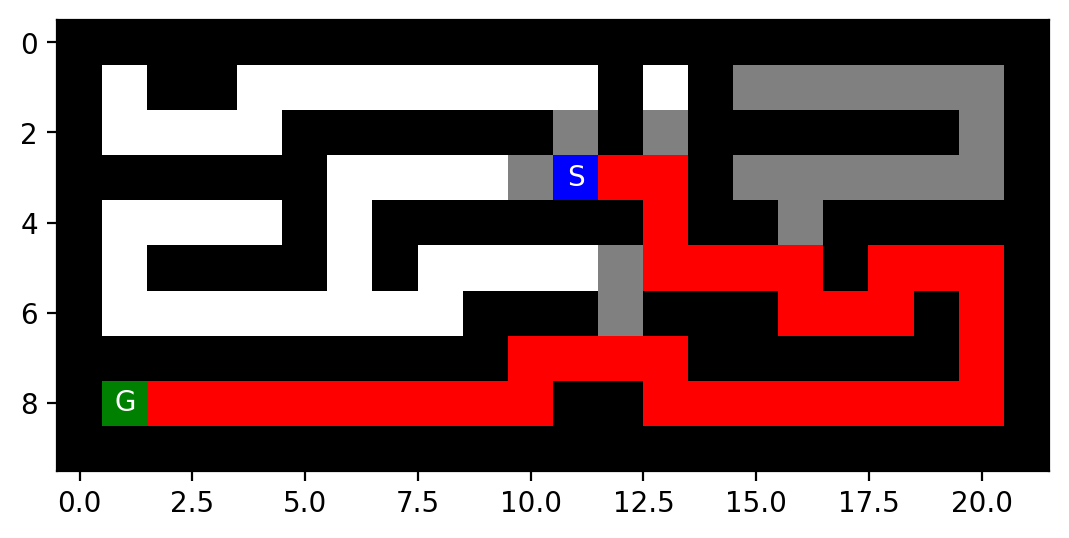

Maze: medium
Path cost: 174
Squares Explored: 182
Max Frontier: 8
Max Depth: 174


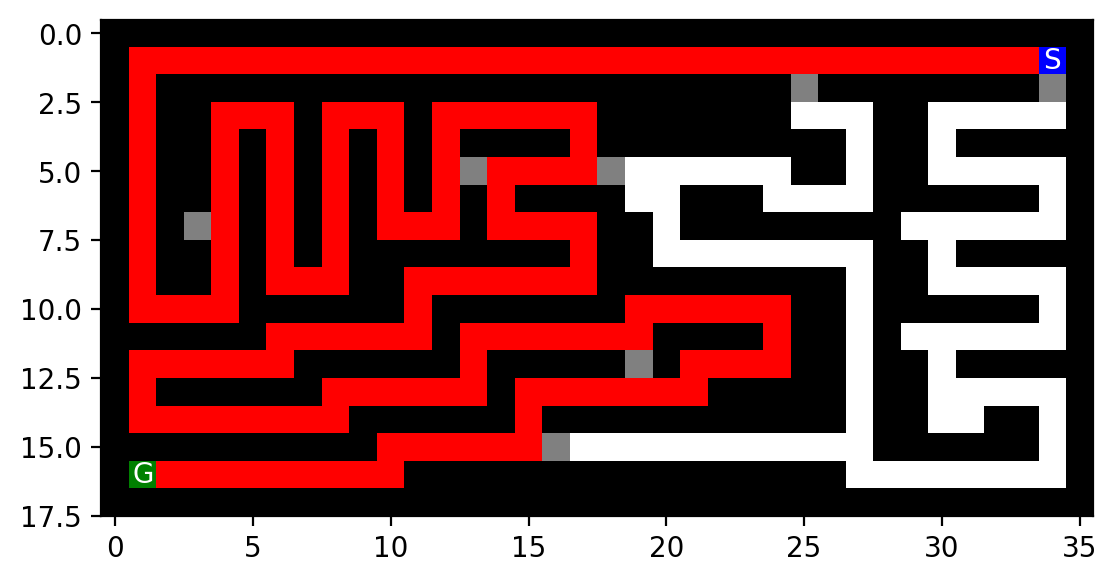

Maze: large
Path cost: 210
Squares Explored: 491
Max Frontier: 35
Max Depth: 222


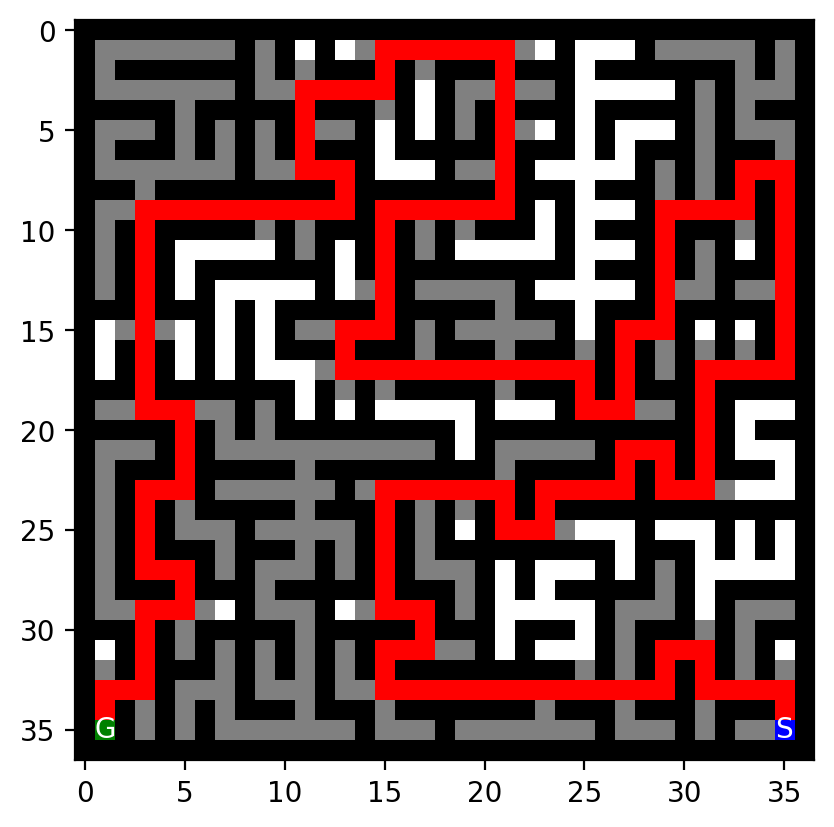

Maze: empty
Path cost: 44
Squares Explored: 94
Max Frontier: 43
Max Depth: 44


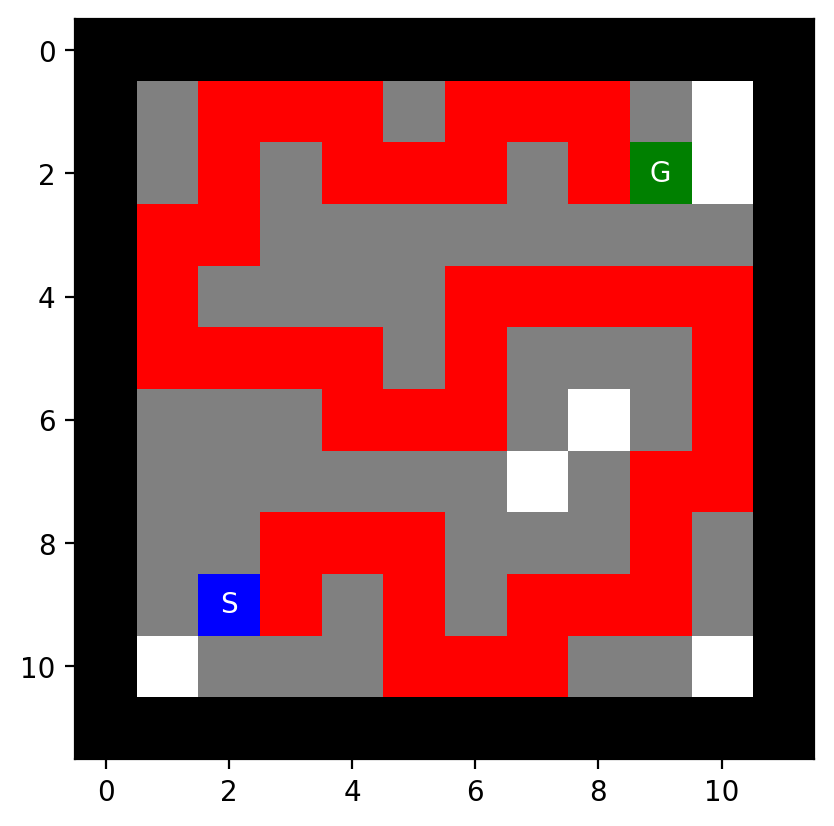

Maze: wall
Path cost: 30
Squares Explored: 151
Max Frontier: 61
Max Depth: 64


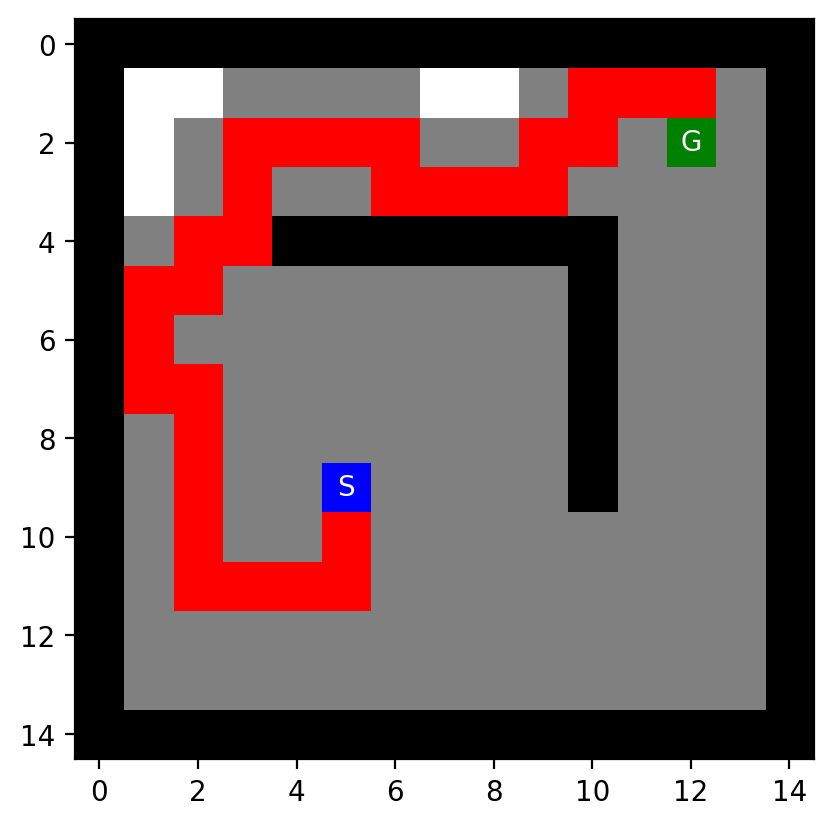

Maze: loops
Path cost: 29
Squares Explored: 41
Max Frontier: 12
Max Depth: 29


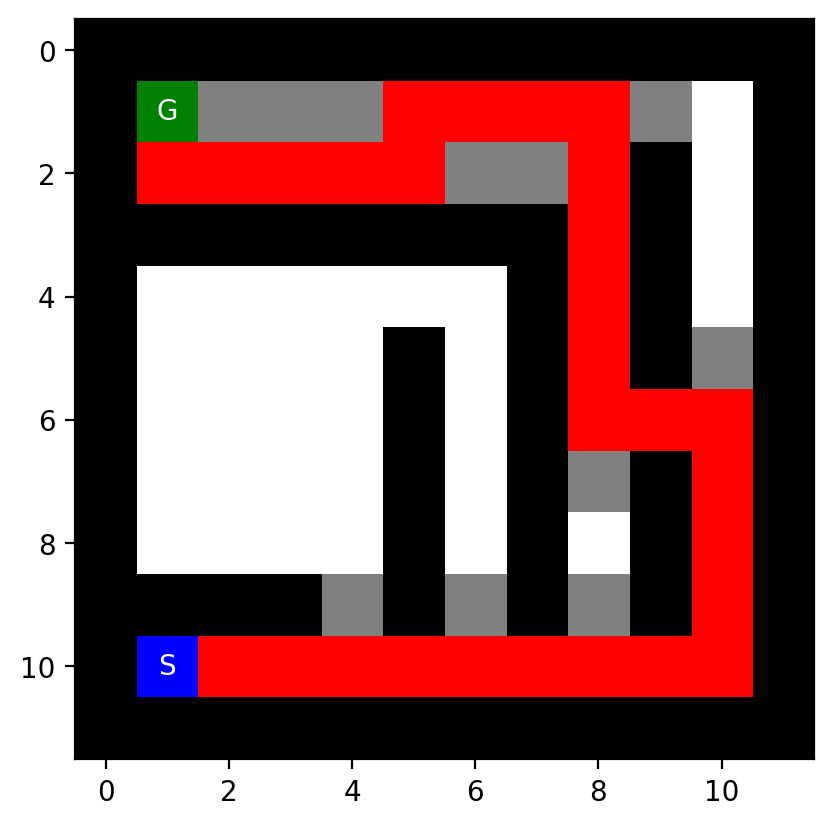

Maze: open
Path cost: 98
Squares Explored: 356
Max Frontier: 121
Max Depth: 123


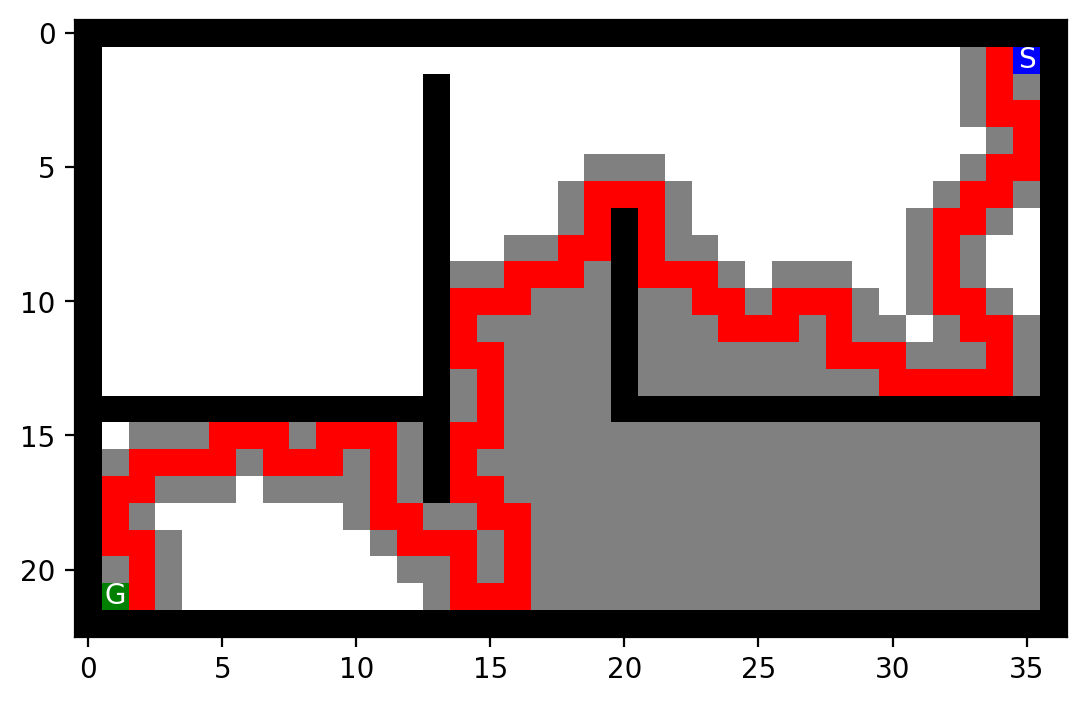

Maze: empty2
Path cost: 18
Squares Explored: 40
Max Frontier: 22
Max Depth: 18


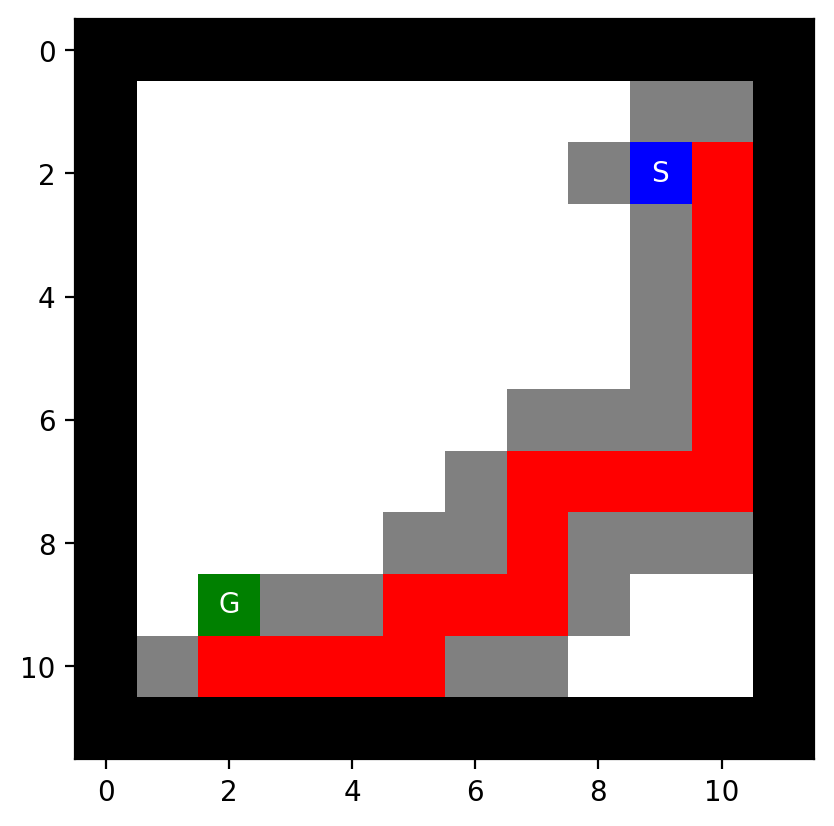

_________________________________________________________________



In [53]:
strategies = ["DFS"]
maze_runner(strategies)

_________________________________________________________________

Strategy: GBFSM

Maze: small
Path cost: 29
Squares Explored: 44
Max Frontier: 5
Max Depth: 29


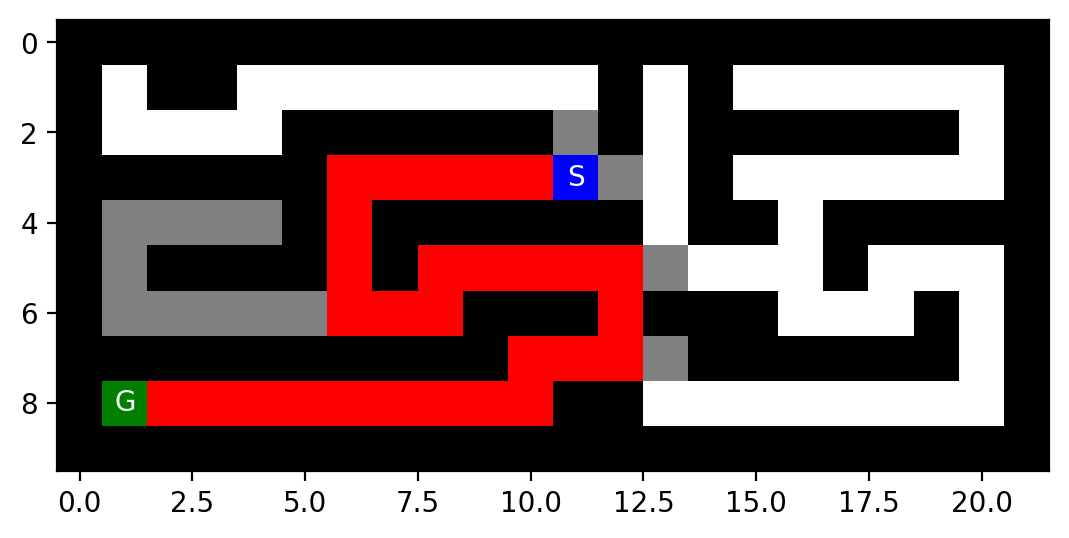

Maze: medium
Path cost: 152
Squares Explored: 164
Max Frontier: 8
Max Depth: 152


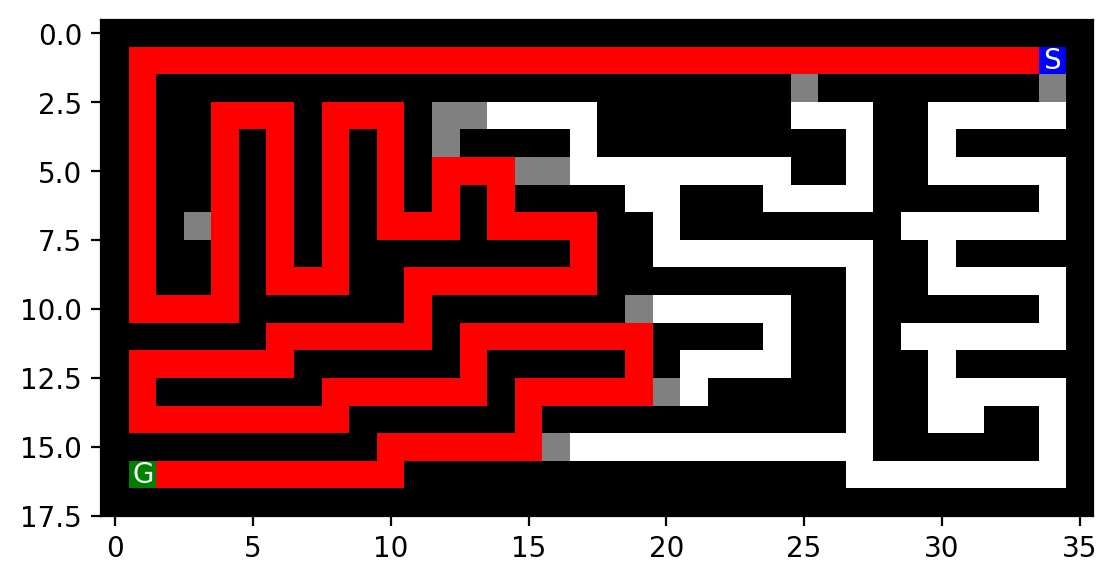

Maze: large
Path cost: 210
Squares Explored: 470
Max Frontier: 26
Max Depth: 210


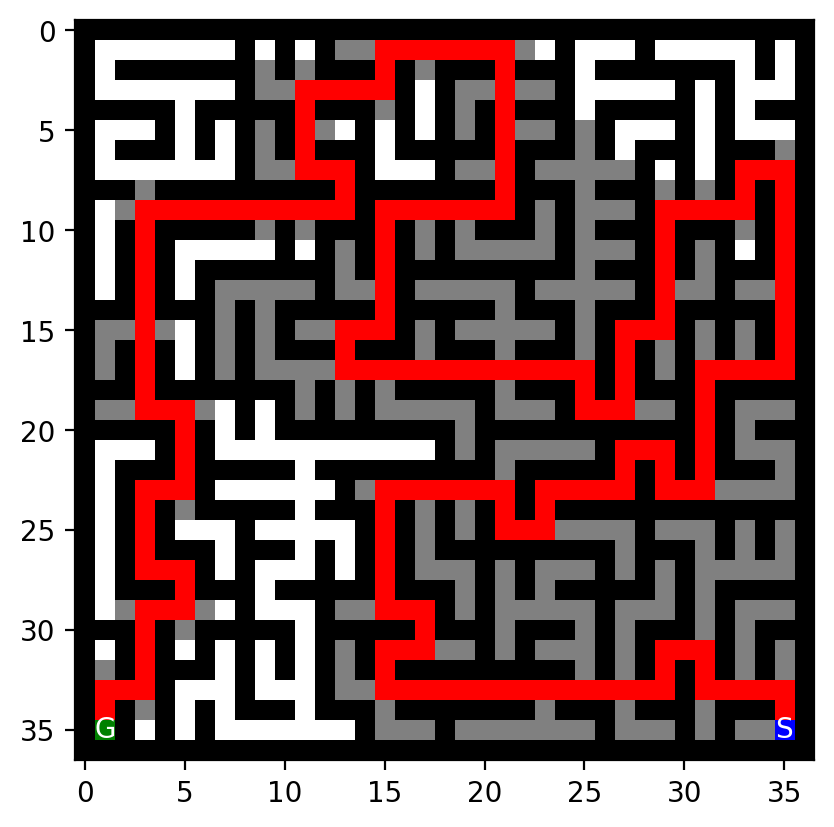

Maze: empty
Path cost: 14
Squares Explored: 41
Max Frontier: 27
Max Depth: 14


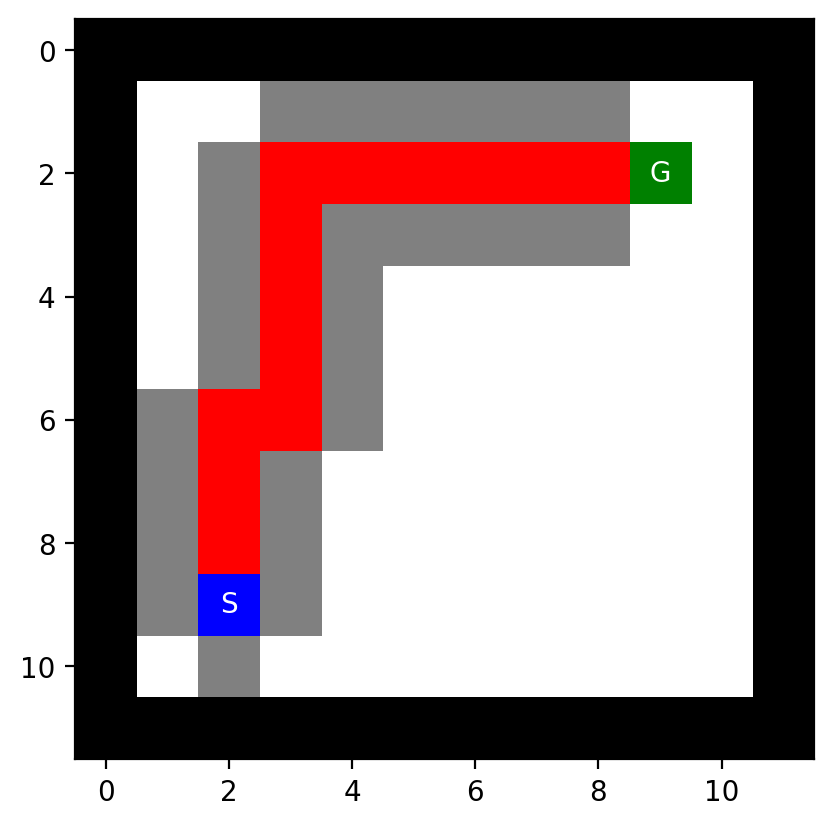

Maze: wall
Path cost: 24
Squares Explored: 61
Max Frontier: 28
Max Depth: 24


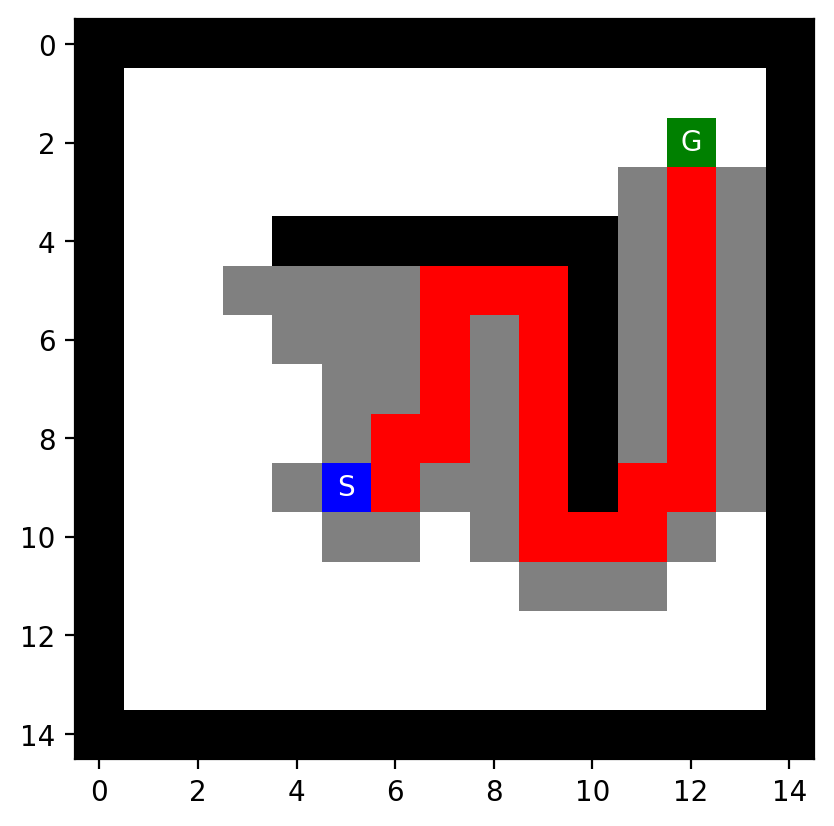

Maze: loops
Path cost: 23
Squares Explored: 60
Max Frontier: 9
Max Depth: 23


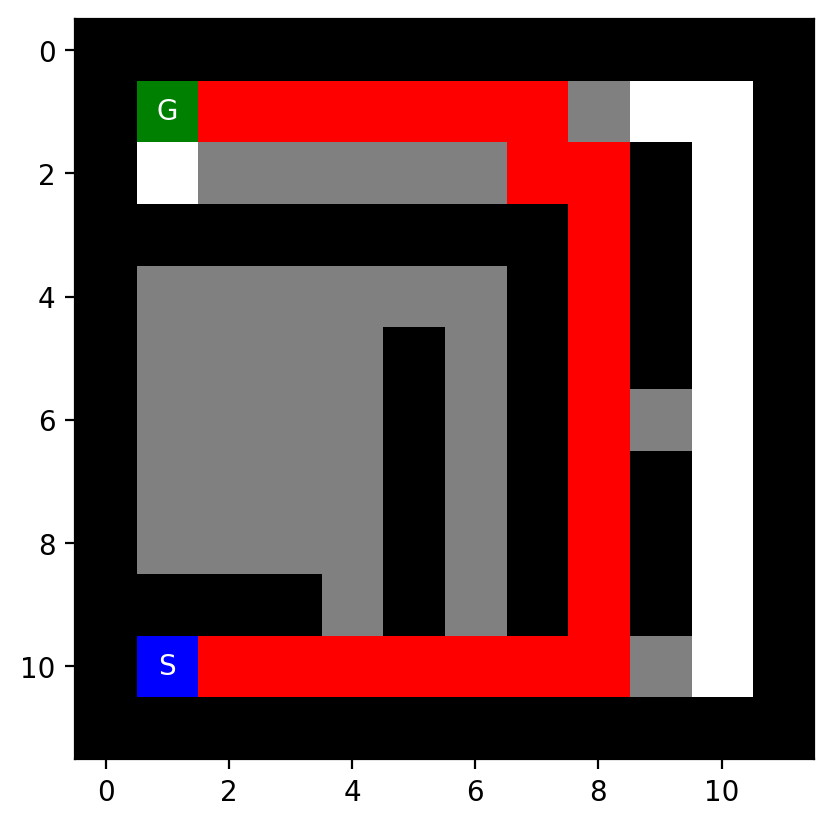

Maze: open
Path cost: 62
Squares Explored: 165
Max Frontier: 79
Max Depth: 62


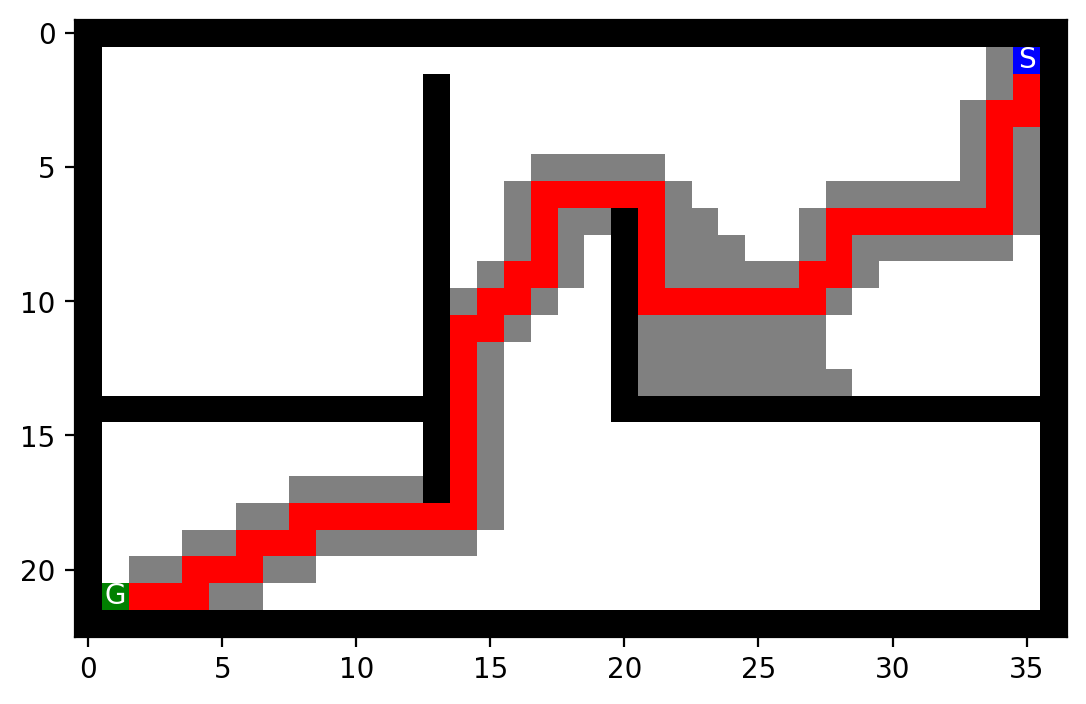

Maze: empty2
Path cost: 14
Squares Explored: 39
Max Frontier: 25
Max Depth: 14


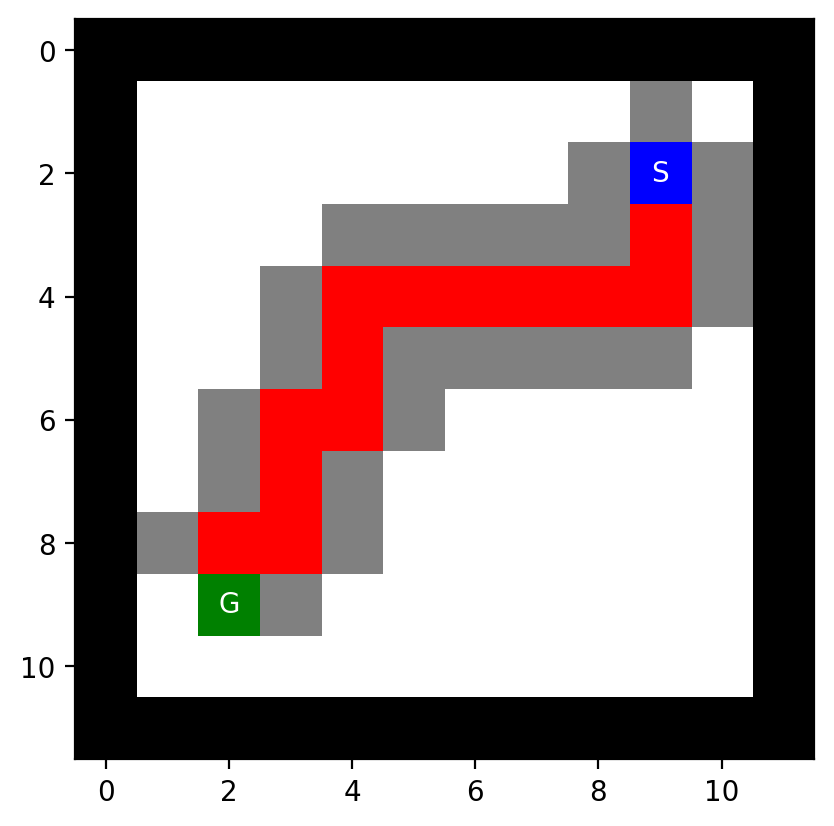

_________________________________________________________________



In [61]:
strategies = ["GBFSM"]
maze_runner(strategies)

_________________________________________________________________

Strategy: A*M

Maze: small
Path cost: 19
Squares Explored: 59
Max Frontier: 7
Max Depth: 19


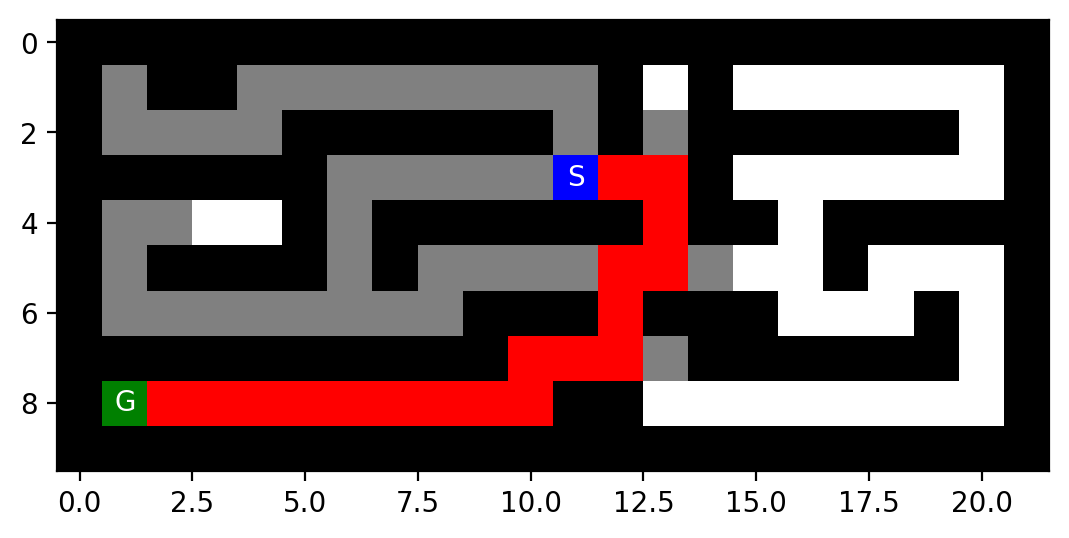

Maze: medium
Path cost: 68
Squares Explored: 228
Max Frontier: 8
Max Depth: 68


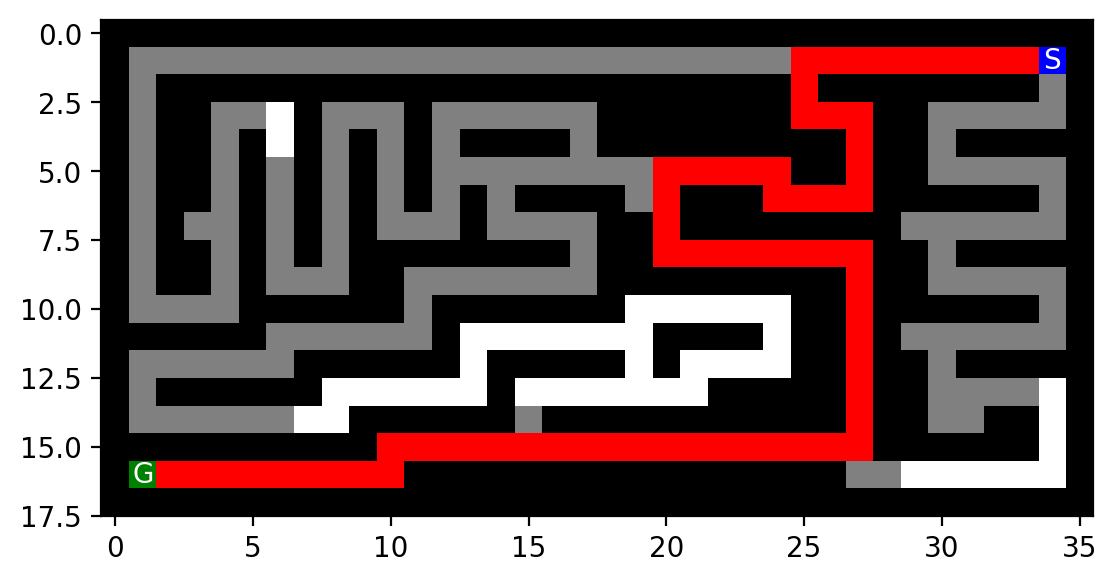

Maze: large
Path cost: 210
Squares Explored: 557
Max Frontier: 12
Max Depth: 210


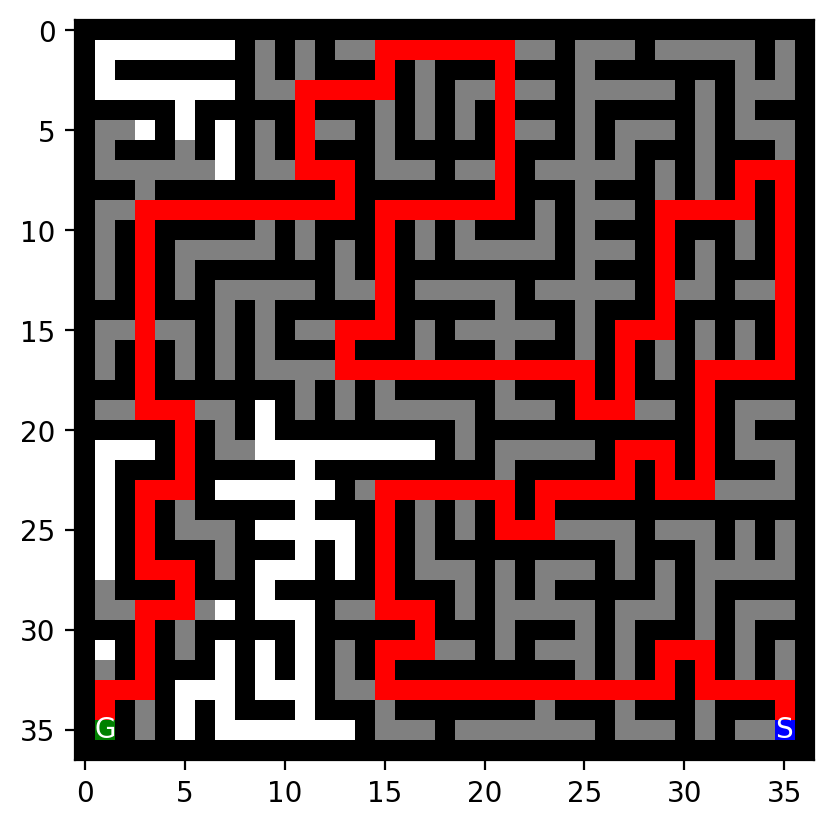

Maze: empty
Path cost: 14
Squares Explored: 91
Max Frontier: 37
Max Depth: 14


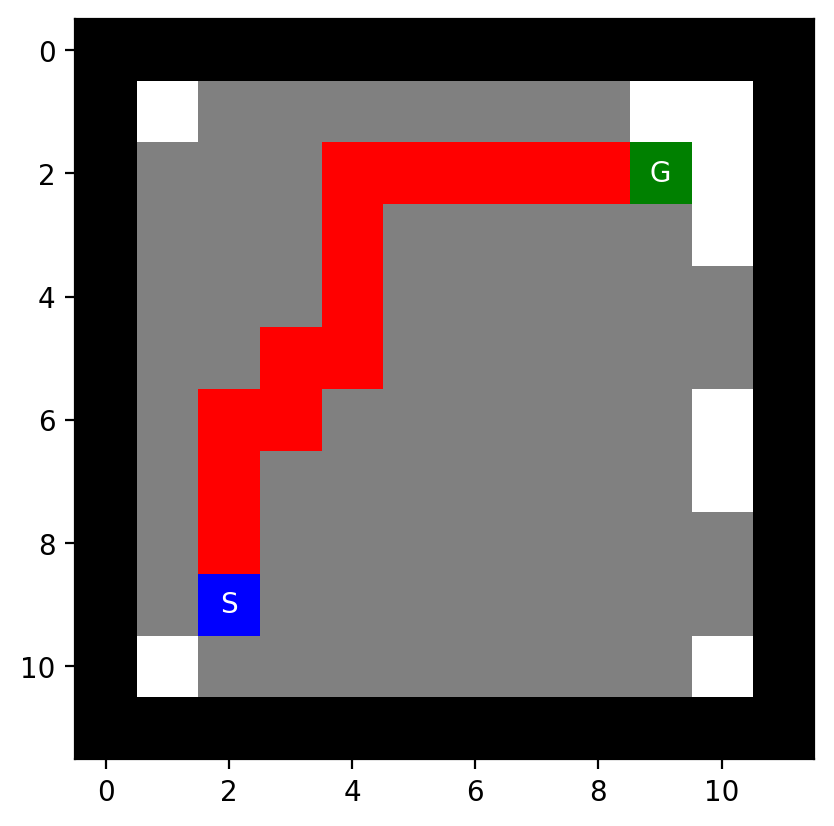

Maze: wall
Path cost: 16
Squares Explored: 76
Max Frontier: 25
Max Depth: 16


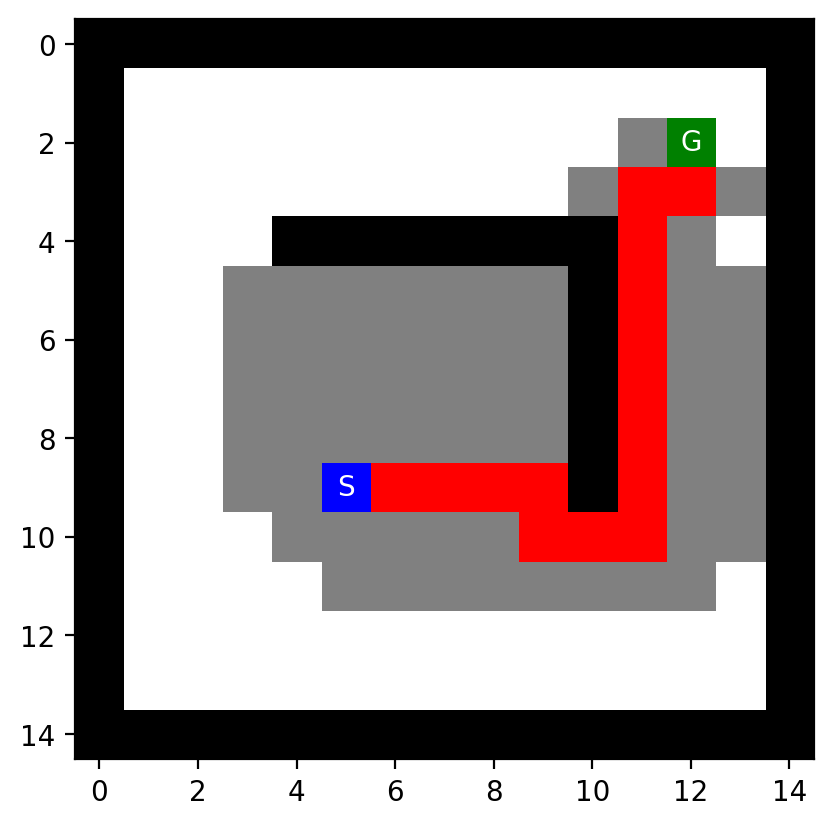

Maze: loops
Path cost: 23
Squares Explored: 62
Max Frontier: 9
Max Depth: 23


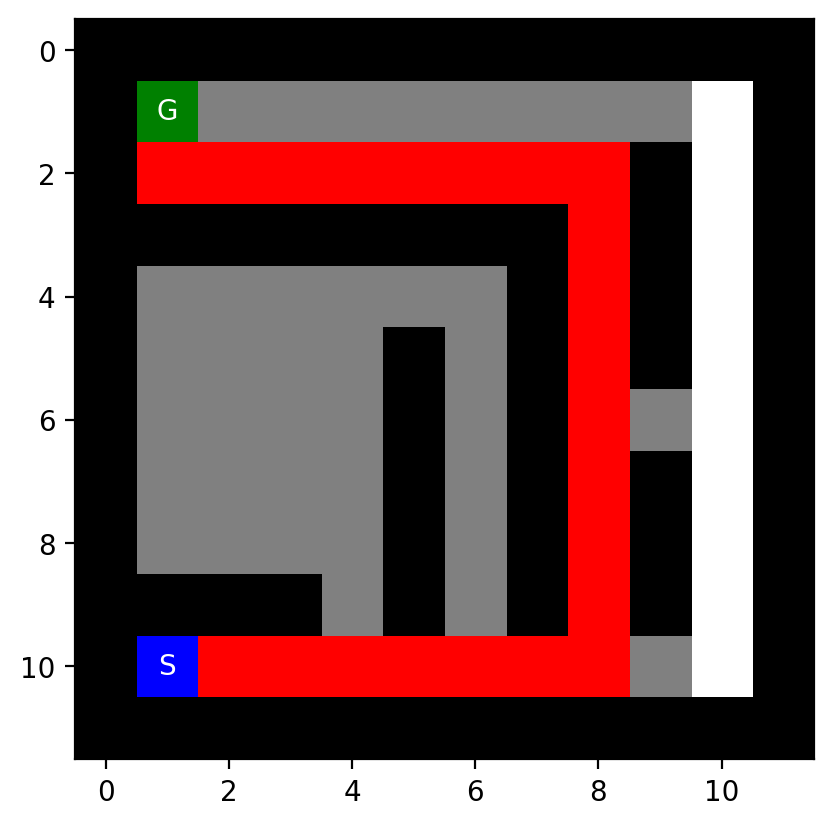

Maze: open
Path cost: 54
Squares Explored: 490
Max Frontier: 93
Max Depth: 54


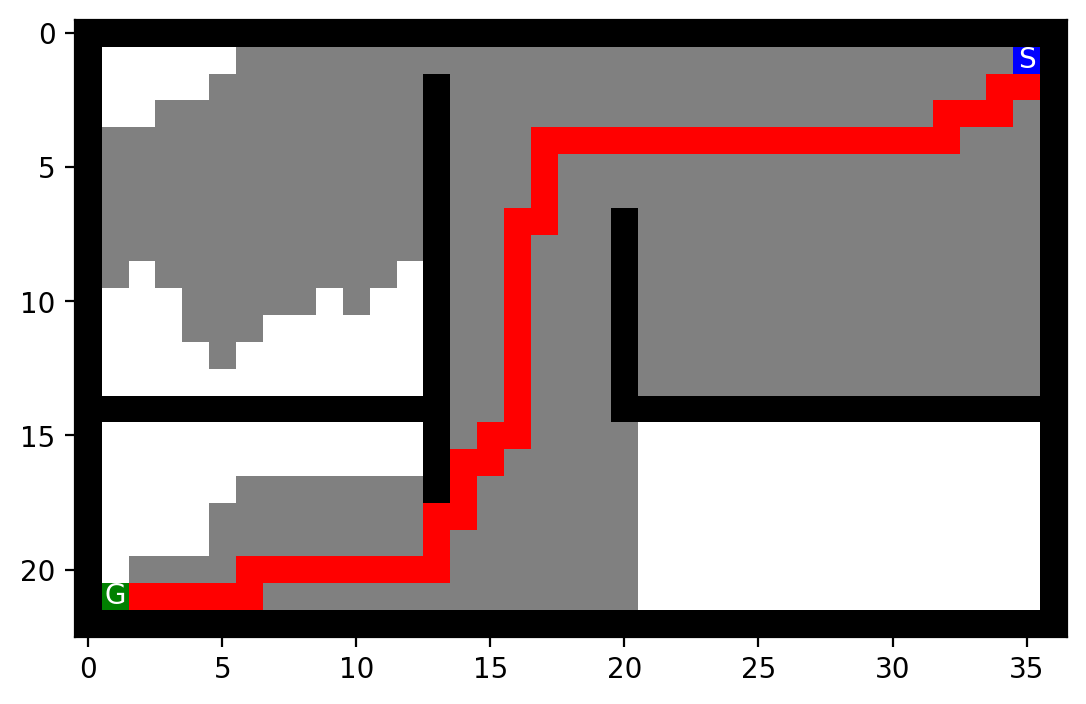

Maze: empty2
Path cost: 14
Squares Explored: 87
Max Frontier: 36
Max Depth: 14


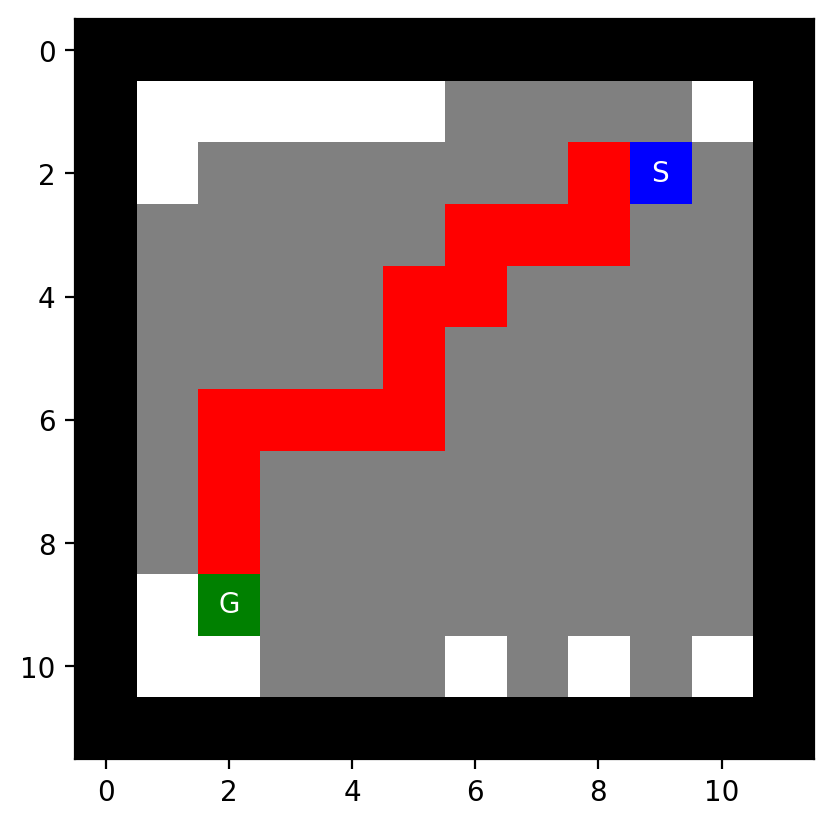

_________________________________________________________________



In [55]:
strategies = ["A*M"]
maze_runner(strategies)

# Tables cho các maze data
 *The solution and its path cost

 *Number of nodes expanded

 *Maximum tree depth searched
 
 *Maximum size of the frontier.

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

df_init = pd.DataFrame({'Strategy': [],'Path Cost': [],'Squares Explored': [],'Max Frontier Size': [],'Max Depth': []})

strategies = ["BFS", "DFS", "IDS", "GBFSM", "A*M"]

for cur_maze in maze_names.keys():
    df = df_init
    for cur_strat in strategies:
        maze = load_maze(cur_maze)
        results = tree_search(maze, strat = cur_strat, debug = False, visualize = False)
        # Dành cho pandas < 2
        # df = df.append({
        #     'Strategy': cur_strat,
        #     'Path Cost': (len(results["path"])-1),
        #     'Squares Explored': (len(results["reached"])),
        #     'Max Frontier Size': results["max-frontier"],
        #     'Max Depth': results["max-depth"]
        # }, ignore_index=True)
        new_row = pd.DataFrame([{
            'Strategy': cur_strat,
            'Path Cost': (len(results["path"]) - 1),
            'Squares Explored': len(results["reached"]),
            'Max Frontier Size': results["max-frontier"],
            'Max Depth': results["max-depth"]
        }])

        df = pd.concat([df, new_row], ignore_index=True)

        
    print("Current Maze: {}".format(cur_maze))
    display(df)

Current Maze: small


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,19.0,94.0,9.0,20.0
1,DFS,29.0,48.0,5.0,29.0
2,IDS,19.0,89.0,7.0,19.0
3,GBFSM,29.0,44.0,5.0,29.0
4,A*M,19.0,59.0,8.0,19.0


Current Maze: medium


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,68.0,273.0,9.0,69.0
1,DFS,154.0,274.0,12.0,154.0
2,IDS,68.0,256.0,8.0,68.0
3,GBFSM,152.0,167.0,8.0,152.0
4,A*M,68.0,228.0,8.0,68.0


Current Maze: large


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,210.0,623.0,8.0,210.0
1,DFS,210.0,471.0,38.0,214.0
2,IDS,210.0,459.0,42.0,210.0
3,GBFSM,210.0,481.0,25.0,210.0
4,A*M,210.0,556.0,11.0,210.0


Current Maze: empty


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,14.0,98.0,12.0,15.0
1,DFS,14.0,38.0,24.0,14.0
2,IDS,14.0,87.0,22.0,14.0
3,GBFSM,14.0,39.0,25.0,14.0
4,A*M,14.0,66.0,30.0,14.0


Current Maze: L


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,16.0,155.0,18.0,17.0
1,DFS,44.0,86.0,41.0,44.0
2,IDS,16.0,151.0,24.0,16.0
3,GBFSM,18.0,62.0,30.0,18.0
4,A*M,16.0,75.0,26.0,16.0


Current Maze: loops


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,23.0,72.0,8.0,23.0
1,DFS,43.0,60.0,16.0,43.0
2,IDS,23.0,71.0,12.0,23.0
3,GBFSM,39.0,61.0,10.0,39.0
4,A*M,23.0,61.0,8.0,23.0


Current Maze: open


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,54.0,684.0,25.0,54.0
1,DFS,146.0,636.0,160.0,173.0
2,IDS,54.0,677.0,66.0,54.0
3,GBFSM,68.0,154.0,70.0,68.0
4,A*M,54.0,386.0,89.0,54.0


Current Maze: empty2


,Strategy,Path Cost,Squares Explored,Max Frontier Size,Max Depth
0,BFS,14.0,98.0,12.0,15.0
1,DFS,28.0,73.0,35.0,38.0
2,IDS,14.0,83.0,21.0,14.0
3,GBFSM,14.0,36.0,22.0,14.0
4,A*M,14.0,79.0,38.0,14.0


Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__

...

Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)). 

In [14]:
# Add charts

Discuss the most important lessons you have learned from implementing the different search strategies. 

In [15]:
# Add discussion

## Advanced task: IDS and Multiple goals

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

### IDS 
Implement IDS (iterative deepening search) using your DFS implementation. Test IDS on the mazes above. You may run into some issues with mazes with open spaces. If you cannot resolve the issues, then report and discuss what causes the problems.

_________________________________________________________________

Strategy: IDS

Maze: small
Path cost: 19
Squares Explored: 92
Max Frontier: 6
Max Depth: 19


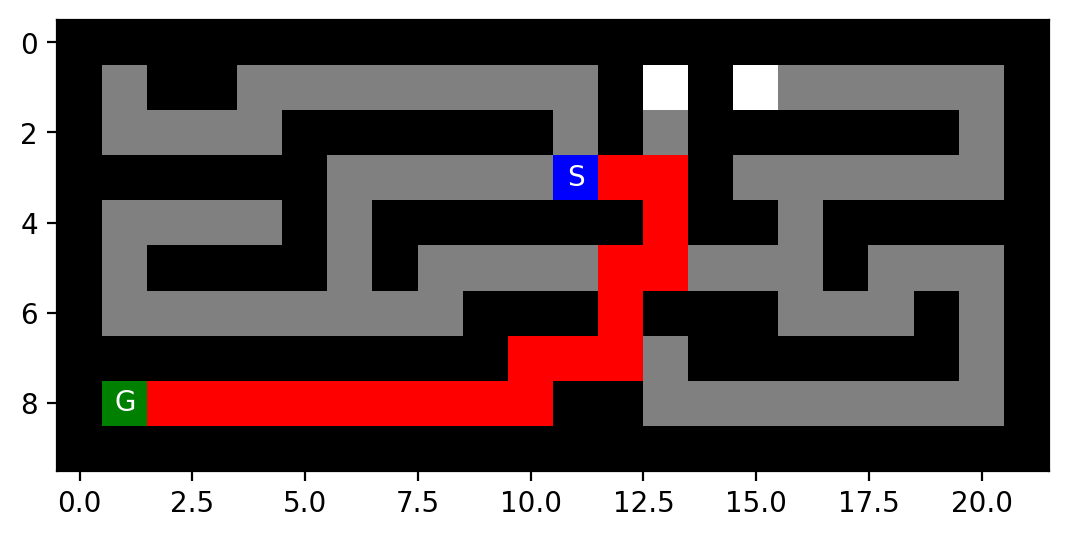

Maze: medium
Path cost: 68
Squares Explored: 271
Max Frontier: 9
Max Depth: 68


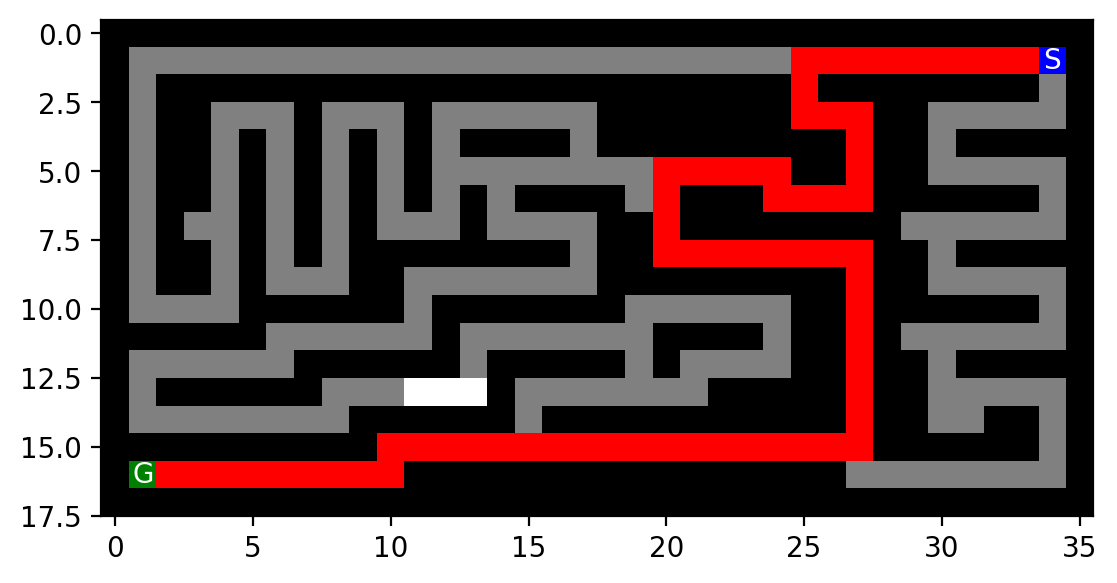

Maze: large
Path cost: 210
Squares Explored: 416
Max Frontier: 41
Max Depth: 210


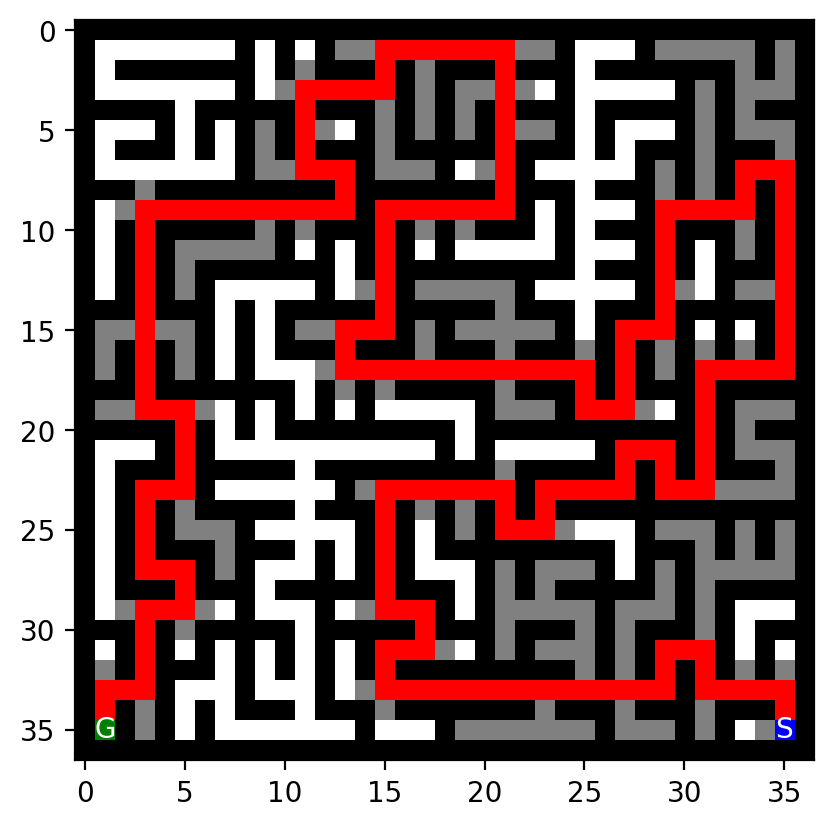

Maze: empty
Path cost: 14
Squares Explored: 93
Max Frontier: 21
Max Depth: 14


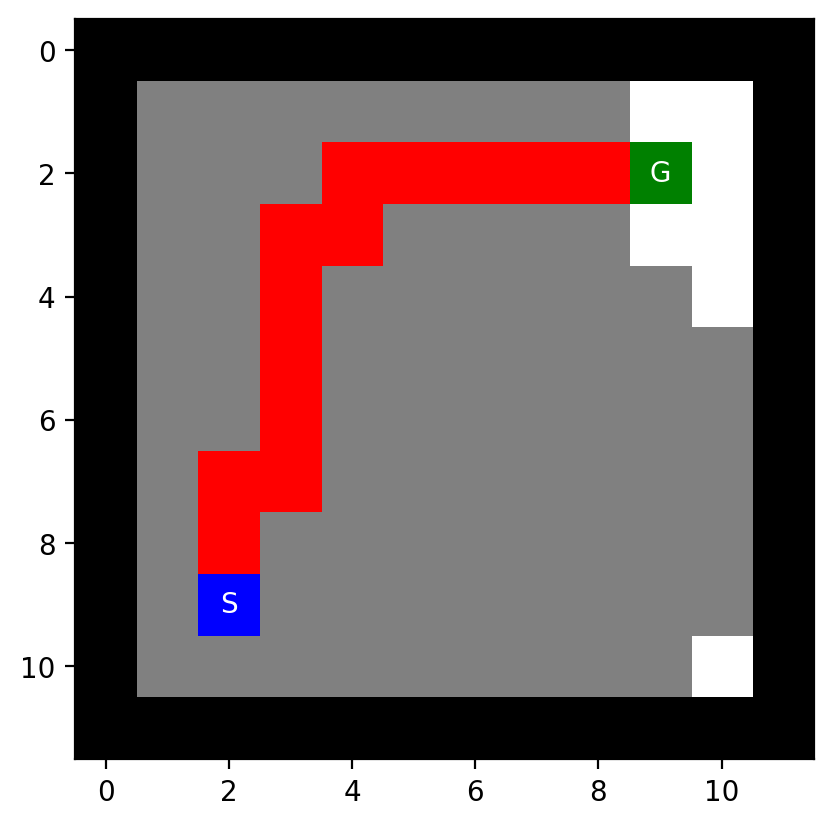

Maze: L
Path cost: 16
Squares Explored: 151
Max Frontier: 23
Max Depth: 16


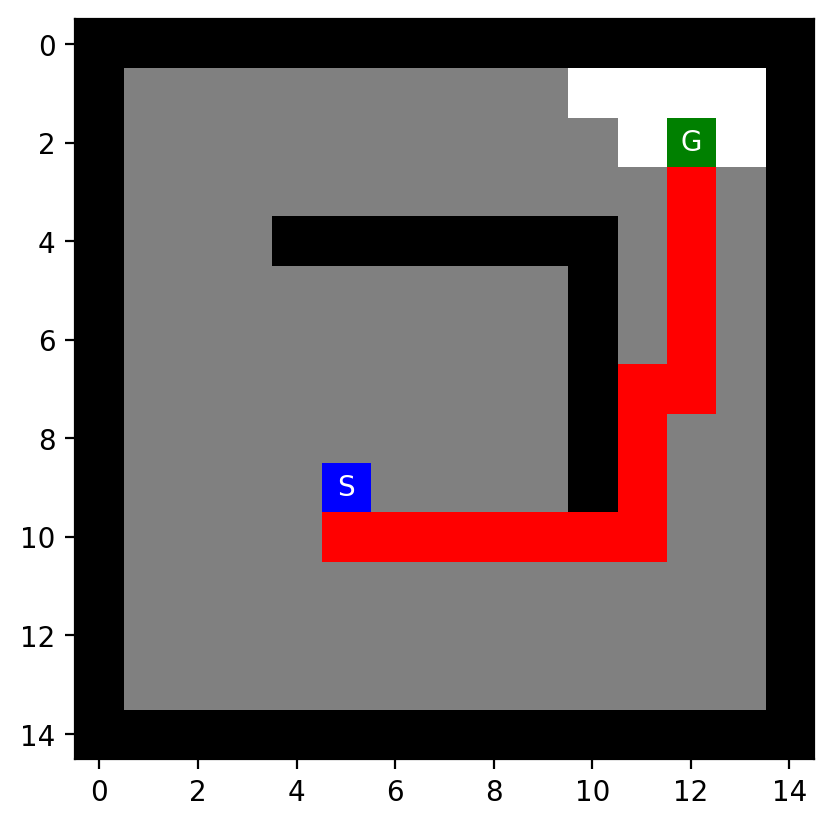

Maze: loops
Path cost: 23
Squares Explored: 63
Max Frontier: 10
Max Depth: 23


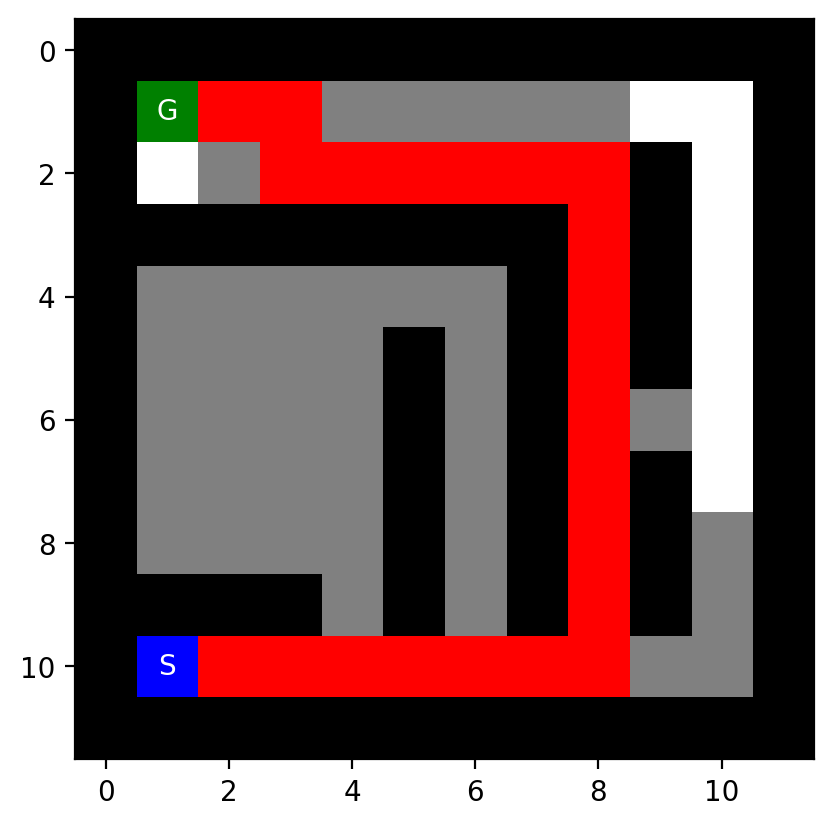

Maze: open
Path cost: 54
Squares Explored: 677
Max Frontier: 63
Max Depth: 54


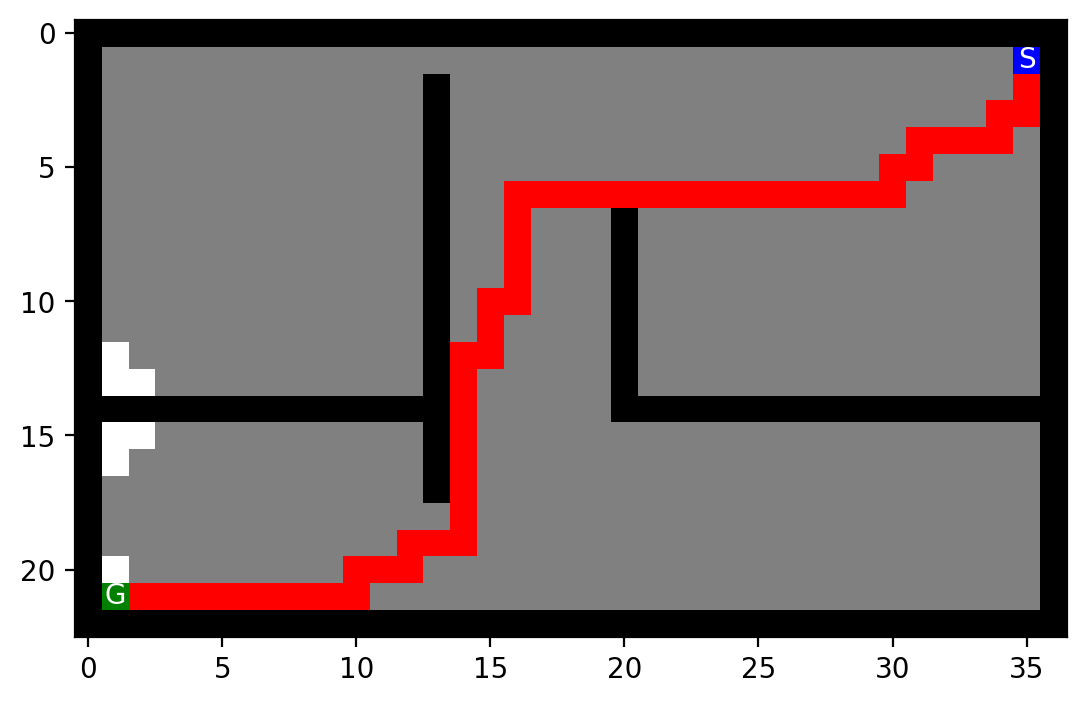

Maze: empty2
Path cost: 14
Squares Explored: 48
Max Frontier: 22
Max Depth: 14


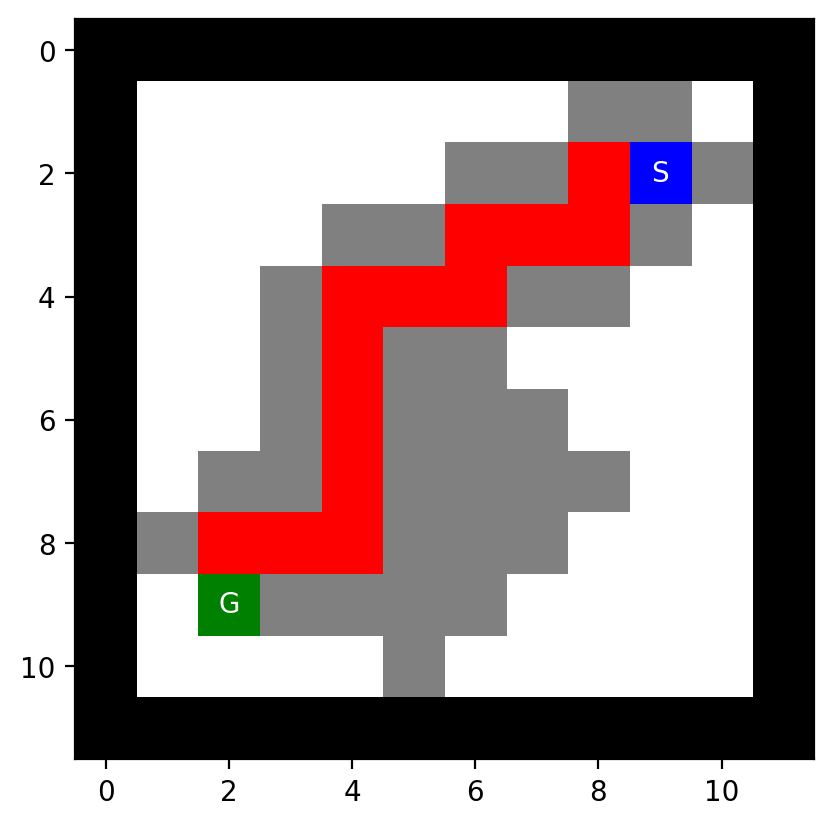

_________________________________________________________________



In [69]:
strategies = ["IDS"]
maze_runner(strategies)

### Multiple Goals 
Create a few mazes with multiple goals by adding one or two more goals to the medium size maze. The agent is done when it finds one of the goals.
Solve the maze with your implementations for DFS, BFS, and IDS. Run experiments to show which implementations find the optimal solution and which do not. Discuss why that is the case.

In [17]:
# Your code/answer goes here

## More Advanced Problems to Think About (not for credit)

If the assignment was to easy for yuo then you can think about the following problems. These problems are challenging and not part of this assignment. 

### Intersection as States
Instead of defining each square as a state, use only intersections as states. Now the storage requirement is reduced, but the path length between two intersections can be different. If we use total path length measured as the number of squares as path cost, how can we make sure that BFS and iterative deepening search is optimal? Change the code to do so.

In [18]:
# Your code/answer goes here

### Weighted A* search
Modify your A* search to add weights (see text book) and explore how different weights influence the result.

In [19]:
# Your code/answer goes here

### Unknown Maze
What happens if the agent does not know the layout of the maze in advance? This means that the agent faces an unknown environment, where it does not know the transition function. How does the environment look then (PEAS description)? How would you implement a rational agent to solve the maze? What if the agent still has a GPS device to tell the distance to the goal?

In [20]:
# Your code/answer goes here